# deepBreaks applications
## Modeling maximum wavelength absorption based on opsin gene amino-acid sequence  
In this study we are trying to use 175 amino-acid sequences to train predictive models for predicting a phenotype which is the the maximum wavelength absobption.  
After that, we use the top 3 models to study their feature importances and merge their results. We cover all three steps of preprocessing, modelling, and interpretaion of the models. Finally we vizualize the results of the models and prioritize the most imposrtant sites of the sequences.  
![alt text](../img/lite_mar/LITE_Mar.png)

In [1]:
# importing deepBreaks libraries 
from deepBreaks import preprocessing as prp
from deepBreaks import visualization as viz
from deepBreaks import models as ml
import os
import datetime
import warnings

In [2]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
# defining user params, file pathes, analysis type

# path to sequences
seqFileName = '/Users/mbagh/Documents/RahLab/deepBreaks_data/lite_mar/msa_RodOpsinLambdaMax.fasta' 

# path to metadata
metaDataFileName = '~/Documents/RahLab/deepBreaks_data/lite_mar/meta_RodOpsinLambdaMax.tsv' 

# name of the phenotype
mt = 'LambdaMax'

# type of the sequences
seq_type = 'amino-acid'

# type of the analysis if it is a classification model, then we put cl instead of reg
anaType = 'reg' 
sampleFrac=1

In [4]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [5]:
%%time
print('reading meta-data')
# importing metadata
metaData = prp.read_data(metaDataFileName, seq_type = None, is_main=False)
print('metaData:', metaData.shape)

# importing sequences data
print('reading fasta file')
df = prp.read_data(seqFileName, seq_type = seq_type, is_main=True)

positions = df.shape[1]
print('Done')
print('Shape of data is: ', df.shape)

reading meta-data
metaData: (175, 2)
reading fasta file
Done
Shape of data is:  (175, 356)
CPU times: user 82.3 ms, sys: 6.88 ms, total: 89.2 ms
Wall time: 94.7 ms


**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [6]:
print('metadata looks like this:')
metaData.head()

metadata looks like this:


Species  LambdaMax
1_KC250344.1_Acipenser_transmontanus  Acipenser_transmontanus      540.0
2_AF137208.1_Amia_calva                            Amia_calva      527.0
3_HQ444181.1_Gymnothorax_favagineus    Gymnothorax_favagineus      488.0
4_HQ444182.1_Gymnothorax_reticularis  Gymnothorax_reticularis      486.0
5_HQ444180.1_Rhinomuraena_quaesita      Rhinomuraena_quaesita      498.0

In [7]:
print('sequence data looks like this:')
df.head()

sequence data looks like this:


p1   p2   p3   p4   p5   p6   p7   p8  \
1_KC250344.1_Acipenser_transmontanus  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2_AF137208.1_Amia_calva               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3_HQ444181.1_Gymnothorax_favagineus   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4_HQ444182.1_Gymnothorax_reticularis  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
5_HQ444180.1_Rhinomuraena_quaesita    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                                       p9  p10  ... p347 p348 p349 p350 p351  \
1_KC250344.1_Acipenser_transmontanus  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
2_AF137208.1_Amia_calva               NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
3_HQ444181.1_Gymnothorax_favagineus   NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
4_HQ444182.1_Gymnothorax_reticularis  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
5_HQ444180.1_Rhinomuraena_quaesita    NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   

                                     p352 p353 p354 p355 p356  
1_KC250344.1_Acipenser_transmontanus  NaN  NaN  NaN  NaN  NaN  
2_AF137208.1_Amia_calva               NaN  NaN  NaN  NaN  NaN  
3_HQ444181.1_Gymnothorax_favagineus   NaN  NaN  NaN  NaN  NaN  
4_HQ444182.1_Gymnothorax_reticularis  NaN  NaN  NaN  NaN  NaN  
5_HQ444180.1_Rhinomuraena_quaesita    NaN  NaN  NaN  NaN  NaN  

[5 rows x 356 columns]

### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [8]:
%%time
# taking care of missing data
print('Shape of data before missing/constant care: ', df.shape)
df = prp.missing_constant_care(df)
print('Shape of data after missing/constant care: ', df.shape)

Shape of data before missing/constant care:  (175, 356)
Shape of data after missing/constant care:  (175, 182)
CPU times: user 84.6 ms, sys: 2.86 ms, total: 87.4 ms
Wall time: 88.8 ms


In [9]:
%%time
# taking care of ultra-rare cases
print('Shape of data before imbalanced care: ', df.shape)
df = prp.imb_care(dat=df, imbalance_threshold=0.025)
print('Shape of data after imbalanced care: ', df.shape)

Shape of data before imbalanced care:  (175, 182)
Shape of data after imbalanced care:  (175, 127)
CPU times: user 190 ms, sys: 5.39 ms, total: 195 ms
Wall time: 192 ms


In [10]:
%%time
# you may want to perform your analysis only on a random sample of the positions.
# Here you can have a random sample of your main data set.
print('number of columns of main data befor: ', df.shape[1])
df = prp.col_sampler(dat=df, sample_frac=sampleFrac)
print('number of columns of main data after: ', df.shape[1])

number of columns of main data befor:  127
number of columns of main data after:  127
CPU times: user 481 µs, sys: 94 µs, total: 575 µs
Wall time: 554 µs


In [11]:
%%time
# Use statistical tests to drop redundant features.
print('number of columns of main data befor: ', df.shape[1])
df_cleaned = prp.redundant_drop(dat=df, meta_dat=metaData,
                        feature=mt, model_type=anaType,
                        threshold=0.25,
                        report_dir=report_dir)
print('number of columns of main data after: ', df_cleaned.shape[1])

number of columns of main data befor:  127
number of columns of main data after:  56
CPU times: user 138 ms, sys: 4.53 ms, total: 143 ms
Wall time: 142 ms


In [12]:
%%time
print('one-hot encoding the dataset')
df_cleaned = prp.get_dummies(dat=df_cleaned, drop_first=True)

one-hot encoding the dataset
CPU times: user 44.3 ms, sys: 3.23 ms, total: 47.6 ms
Wall time: 46.1 ms


In [13]:
%%time
print('calculating the distance matrix')
cr = prp.distance_calc(dat=df_cleaned,
                       dist_method='correlation',
                       report_dir=report_dir)
print(cr.shape)

calculating the distance matrix
(111, 111)
CPU times: user 38.8 ms, sys: 5.96 ms, total: 44.8 ms
Wall time: 43.8 ms


In [14]:
print('The distance matrix looks like this.\n The values are between 0 (exact the same) and 1 (non-related).')
cr.head()

The distance matrix looks like this.
 The values are between 0 (exact the same) and 1 (non-related).


p96_WF     p96_Y    p108_L    p108_T   p108_VM    p111_N    p122_I  \
p96_WF   0.000000  0.439888  0.873463  0.877691  0.380657  0.962464  0.964993   
p96_Y    0.439888  0.000000  0.732905  0.781635  0.676094  0.676094  0.937500   
p108_L   0.873463  0.732905  0.000000  0.186031  0.750197  0.860590  0.825859   
p108_T   0.877691  0.781635  0.186031  0.000000  0.843907  0.959654  0.837152   
p108_VM  0.380657  0.676094  0.750197  0.843907  0.000000  0.952096  0.905062   

           p122_M    p122_Q    p124_G  ...    p282_T    p286_L    p286_V  \
p96_WF   0.943746  0.970588  0.883895  ...  0.940148  0.929986  0.794878   
p96_Y    0.899566  0.947489  0.792711  ...  0.844402  0.991667  0.951408   
p108_L   0.751529  0.942663  0.530998  ...  0.601686  0.708196  0.689149   
p108_T   0.806882  0.904641  0.569254  ...  0.666071  0.708847  0.649367   
p108_VM  0.928207  0.962464  0.971375  ...  0.923616  0.910647  0.738218   

           p289_T    p292_S    p297_G    p297_S    p297_T    p299_S    p307_V  
p96_WF   0.955584  0.896079  0.960067  0.882353  0.931628  0.889096  0.924142  
p96_Y    0.742884  0.952629  0.928706  0.789958  0.877932  0.979692  0.337878  
p108_L   0.963086  0.963287  0.795988  0.967377  0.578496  0.673404  0.663440  
p108_T   0.815298  0.995792  0.833940  0.970978  0.581545  0.661471  0.967920  
p108_VM  0.943316  0.867373  0.949037  0.974194  0.848662  0.965636  0.963696  

[5 rows x 111 columns]

In [15]:
%%time
print('finding colinear groups')
dc_df = prp.db_grouped(dat=cr,
                       report_dir=report_dir,
                       threshold=.25, needs_pivot=False)

finding colinear groups
CPU times: user 111 ms, sys: 34.5 ms, total: 146 ms
Wall time: 232 ms


In [16]:
print('The result of the last step is a dataframe with two columns,\
1)feature and 2)group.\nif there are no groups, it will be an empty dataframe')
dc_df.head()

The result of the last step is a dataframe with two columns,1)feature and 2)group.
if there are no groups, it will be an empty dataframe


feature group
0  p96_WF    g0
2  p108_L    g1
3  p108_T    g1
5  p111_N    g2
7  p122_M    g3

Then, we pass the above calculated groupes into the *group_feature* function. This function finds the distance of all the group members to the center of the group (median). The result will be a dictionary of columns like this:  
\
{\
group1_representativ:[member1, member2,...],  
group2_representativ:[member1, member2,...],...  
}

In [17]:
%%time
print('grouping features')
dc = prp.group_features(dat=df_cleaned,
                        group_dat=dc_df,
                        report_dir=report_dir)

grouping features
CPU times: user 52.6 ms, sys: 3.93 ms, total: 56.5 ms
Wall time: 54.7 ms


In [18]:
print('dropping correlated features')
print('Shape of data before collinearity care: ', df_cleaned.shape)
df_cleaned = prp.cor_remove(df_cleaned, dc)
print('Shape of data after collinearity care: ', df_cleaned.shape)

dropping correlated features
Shape of data before collinearity care:  (175, 111)
Shape of data after collinearity care:  (175, 79)


In [19]:
# merge with metadata
df = df.merge(metaData[mt], left_index=True, right_index=True)
df_cleaned = df_cleaned.merge(metaData[mt], left_index=True, right_index=True)

## Modelling
In this step, we try to fit multiple models to the training dataset and rank them based on their performance. By default, we select the top 3 three models for further analysis.  
During this step, deepBreaks creates a CSV file containing all the fitted models with their performance metrics. These metrics are based on an average of 10-fold cross-validation.

In [20]:
%%time
models_to_select = 3 # number of top models to select
top_models, train_cols, model_names = ml.fit_models(dat = df_cleaned,
                                                    meta_var=mt,
                                                    model_type=anaType, 
                                                    models_to_select=models_to_select,
                                                    report_dir=report_dir)

CPU times: user 4.21 s, sys: 1.69 s, total: 5.9 s
Wall time: 7.03 s


## Interpretation 
In this step, we use the training data set, positions, and the top models to report the most discriminative positions in the sequences associated with the phenotype.  
we report the feature importances for all top models separately and make a box plot (regression) or stacked bar plot (classification) for the top 4 positions.

Random Forest RegressorDone
Random Forest Regressor  Done
Extreme Gradient BoostingDone
Extreme Gradient Boosting  Done
Bayesian RidgeDone
Bayesian Ridge  Done


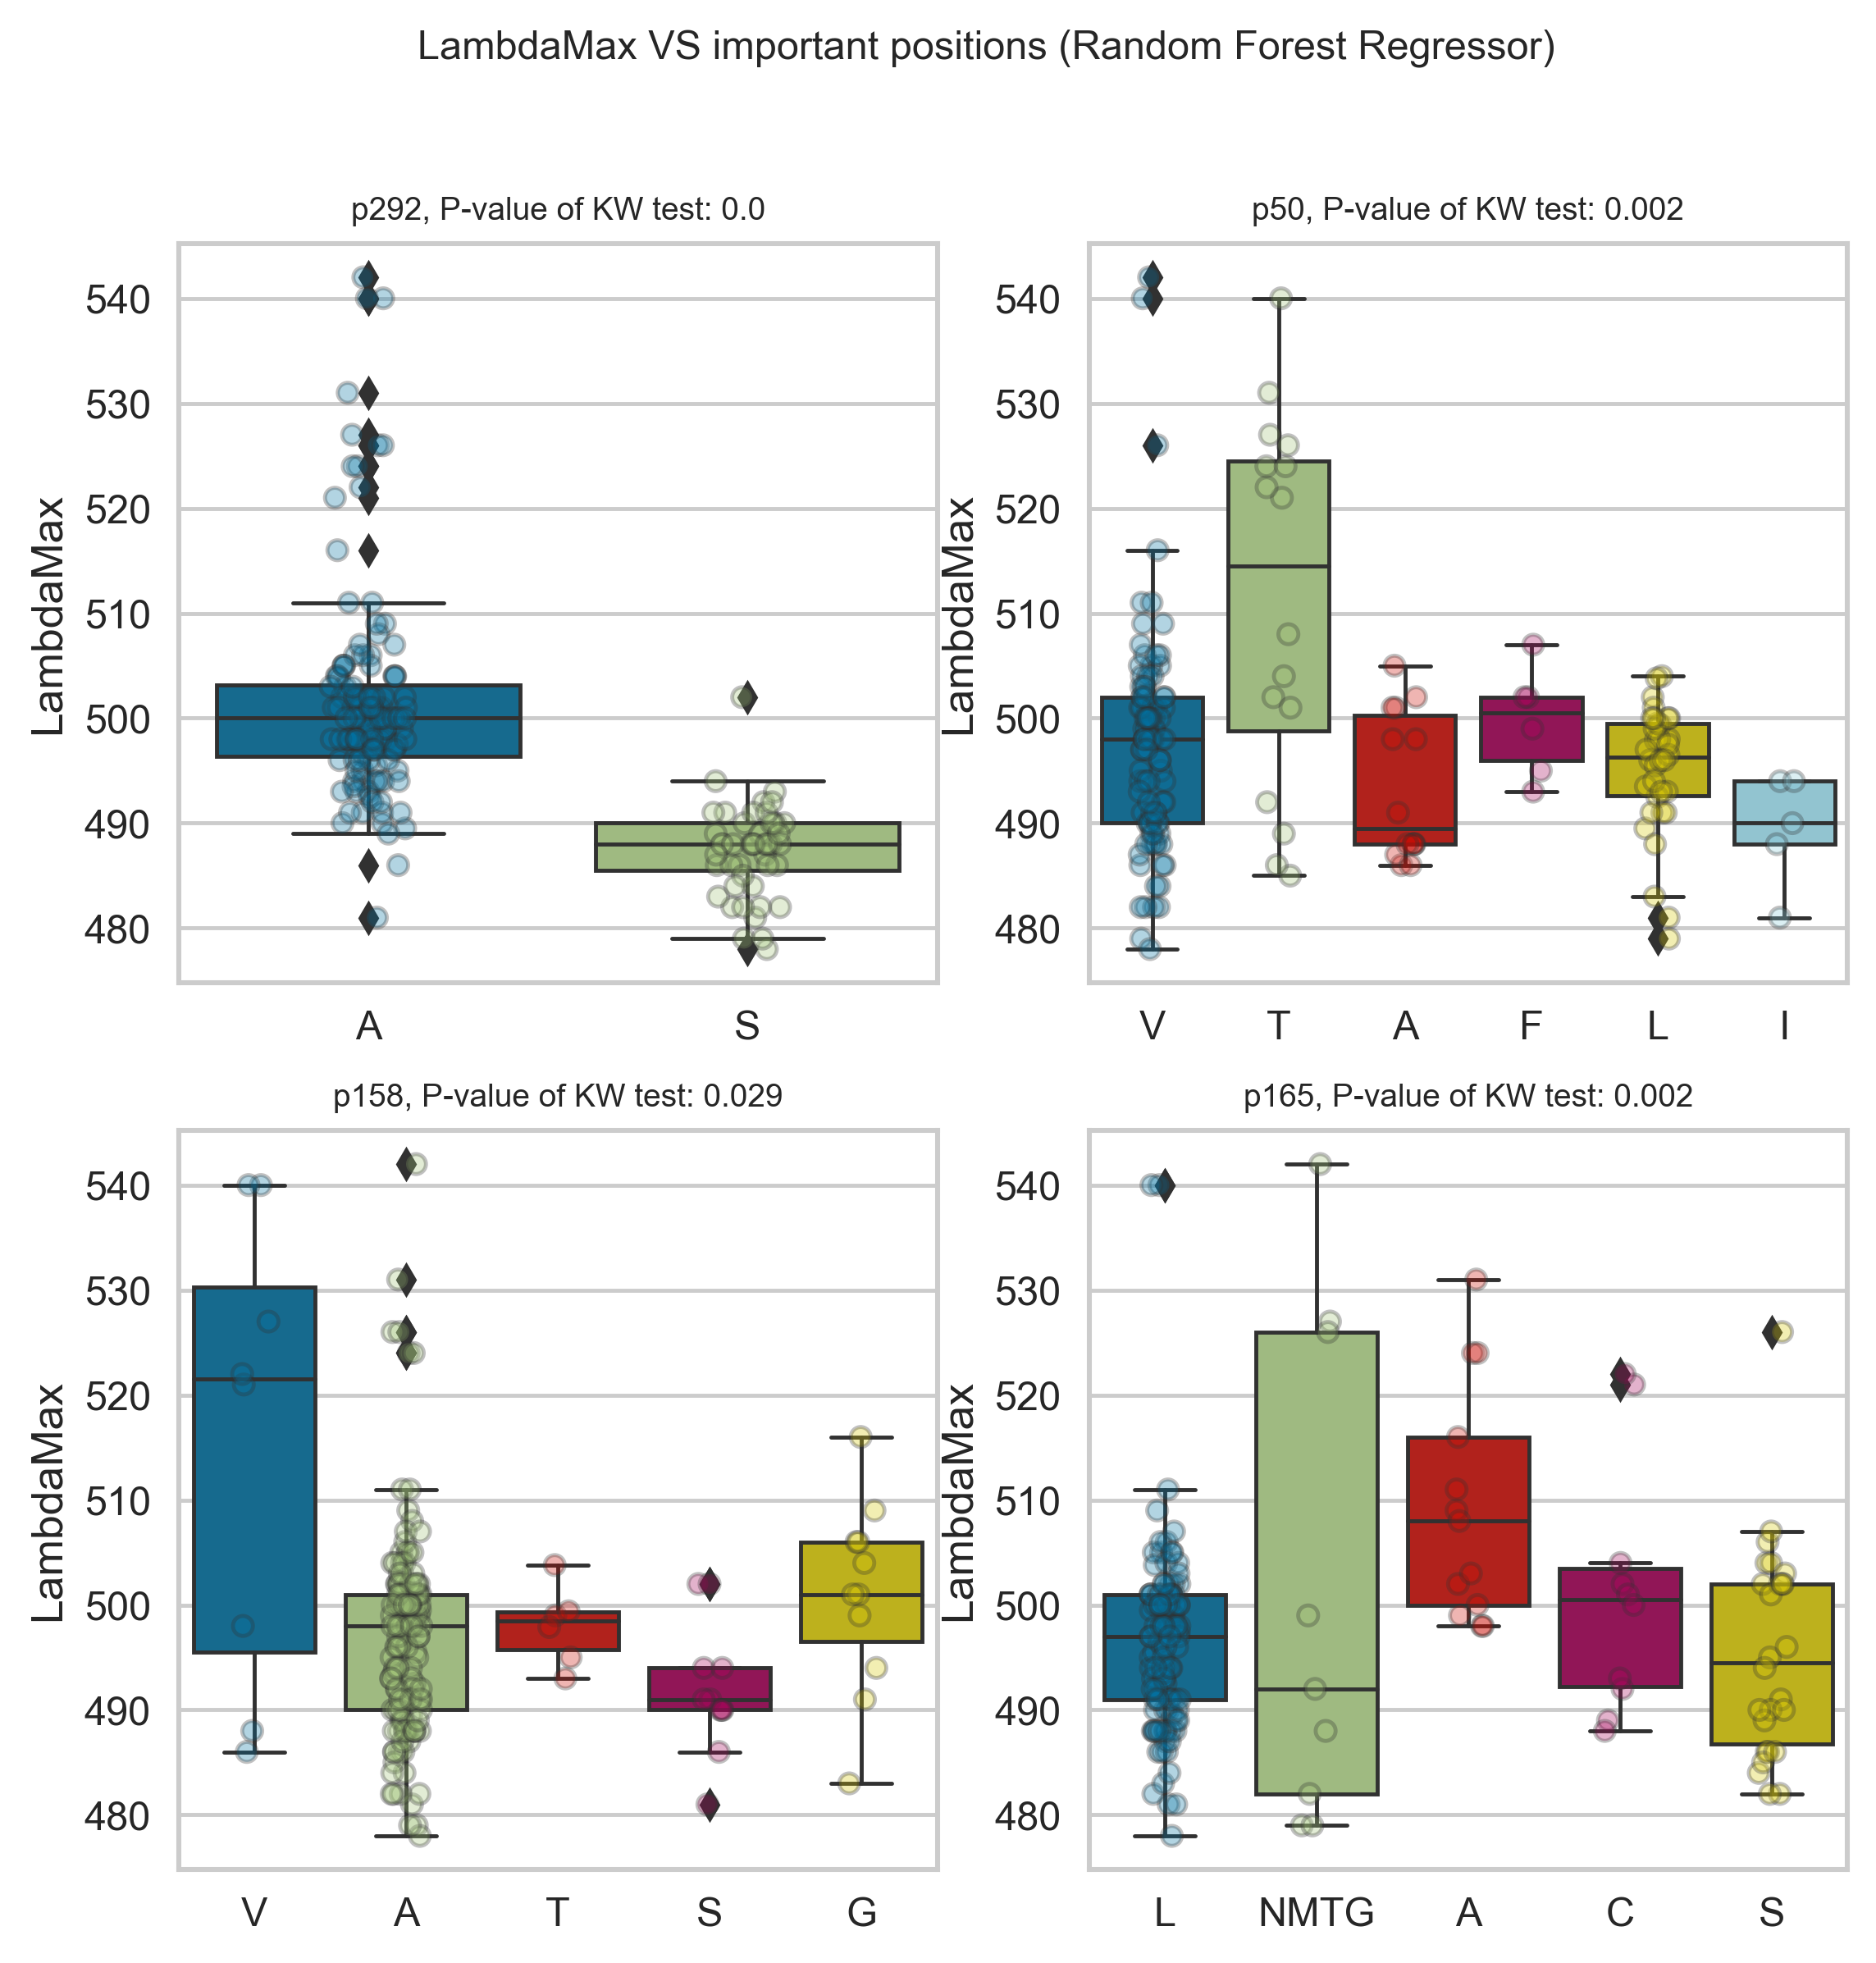

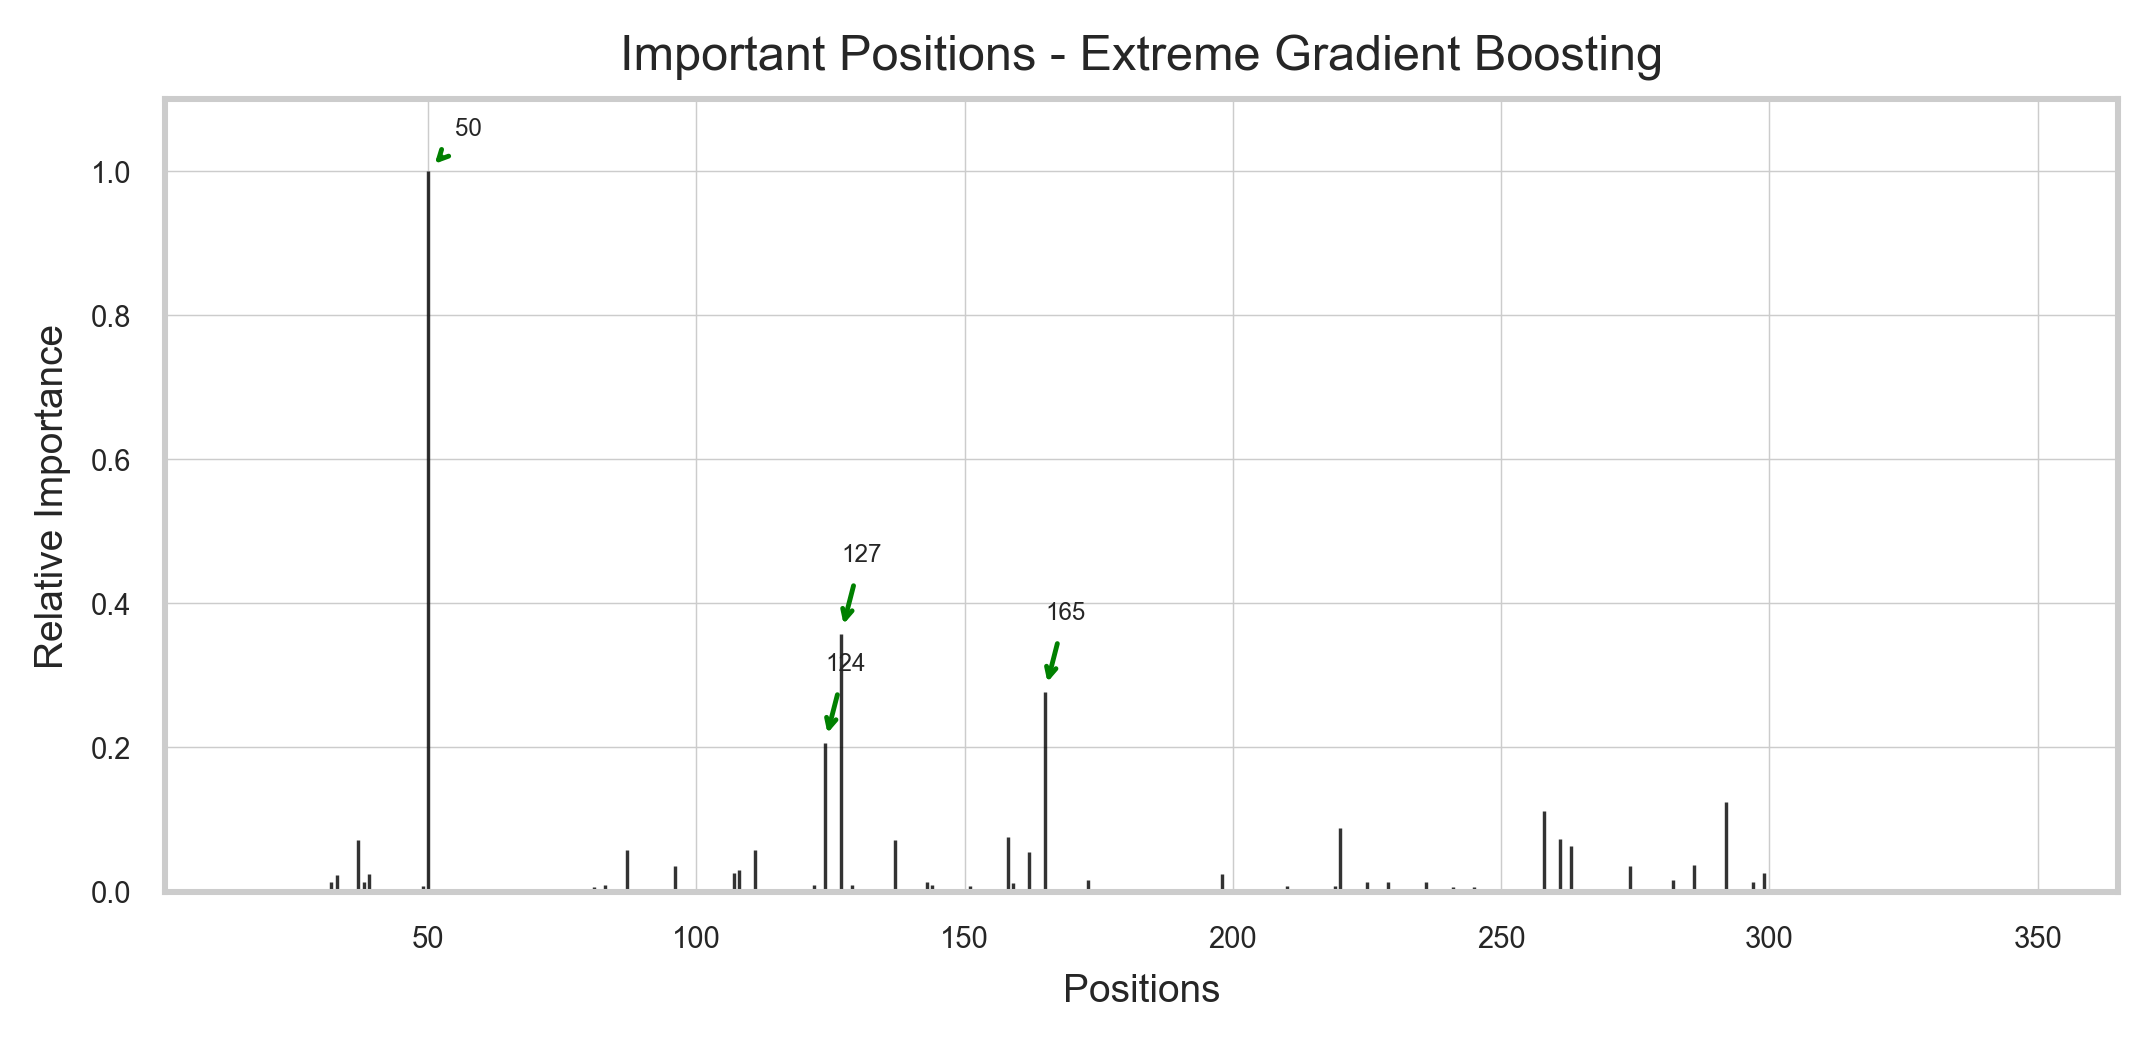

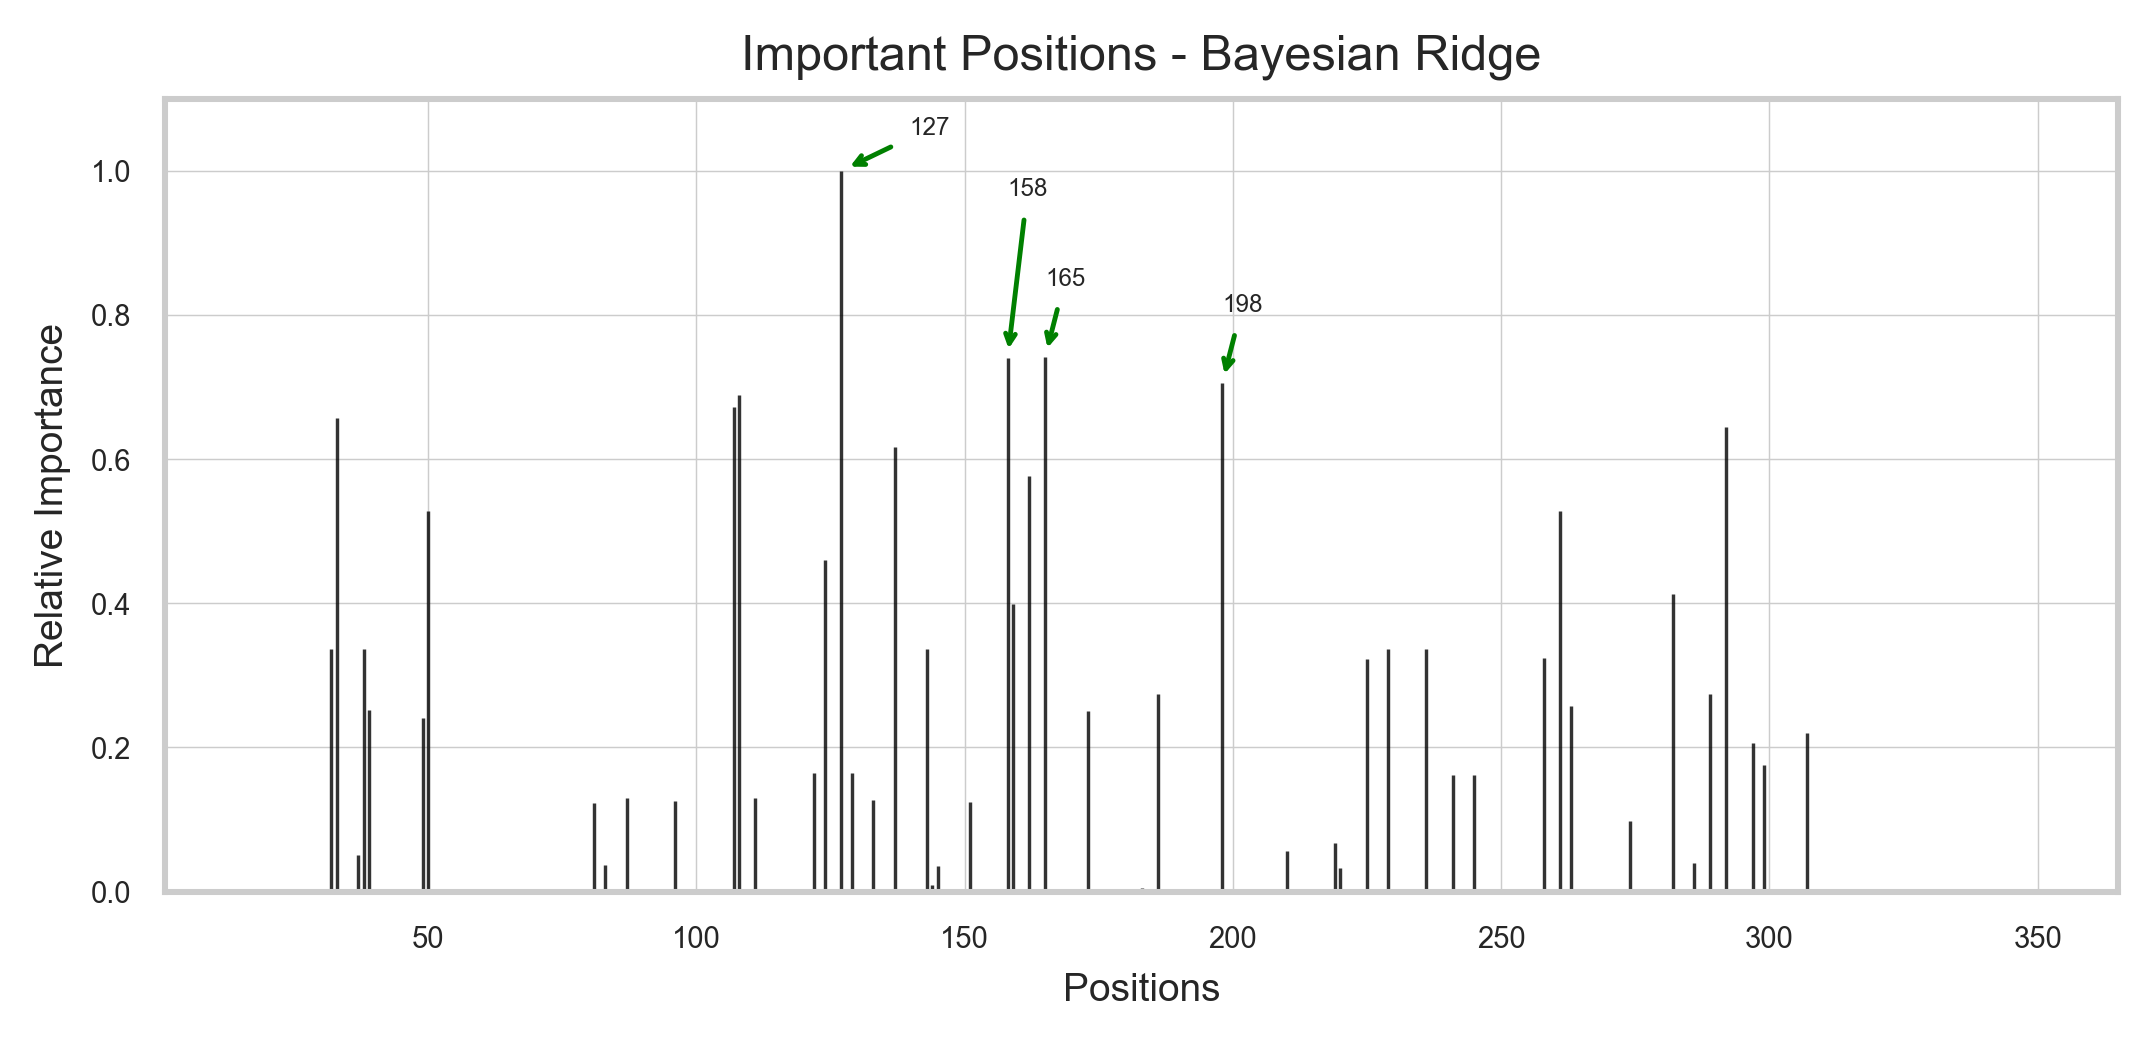

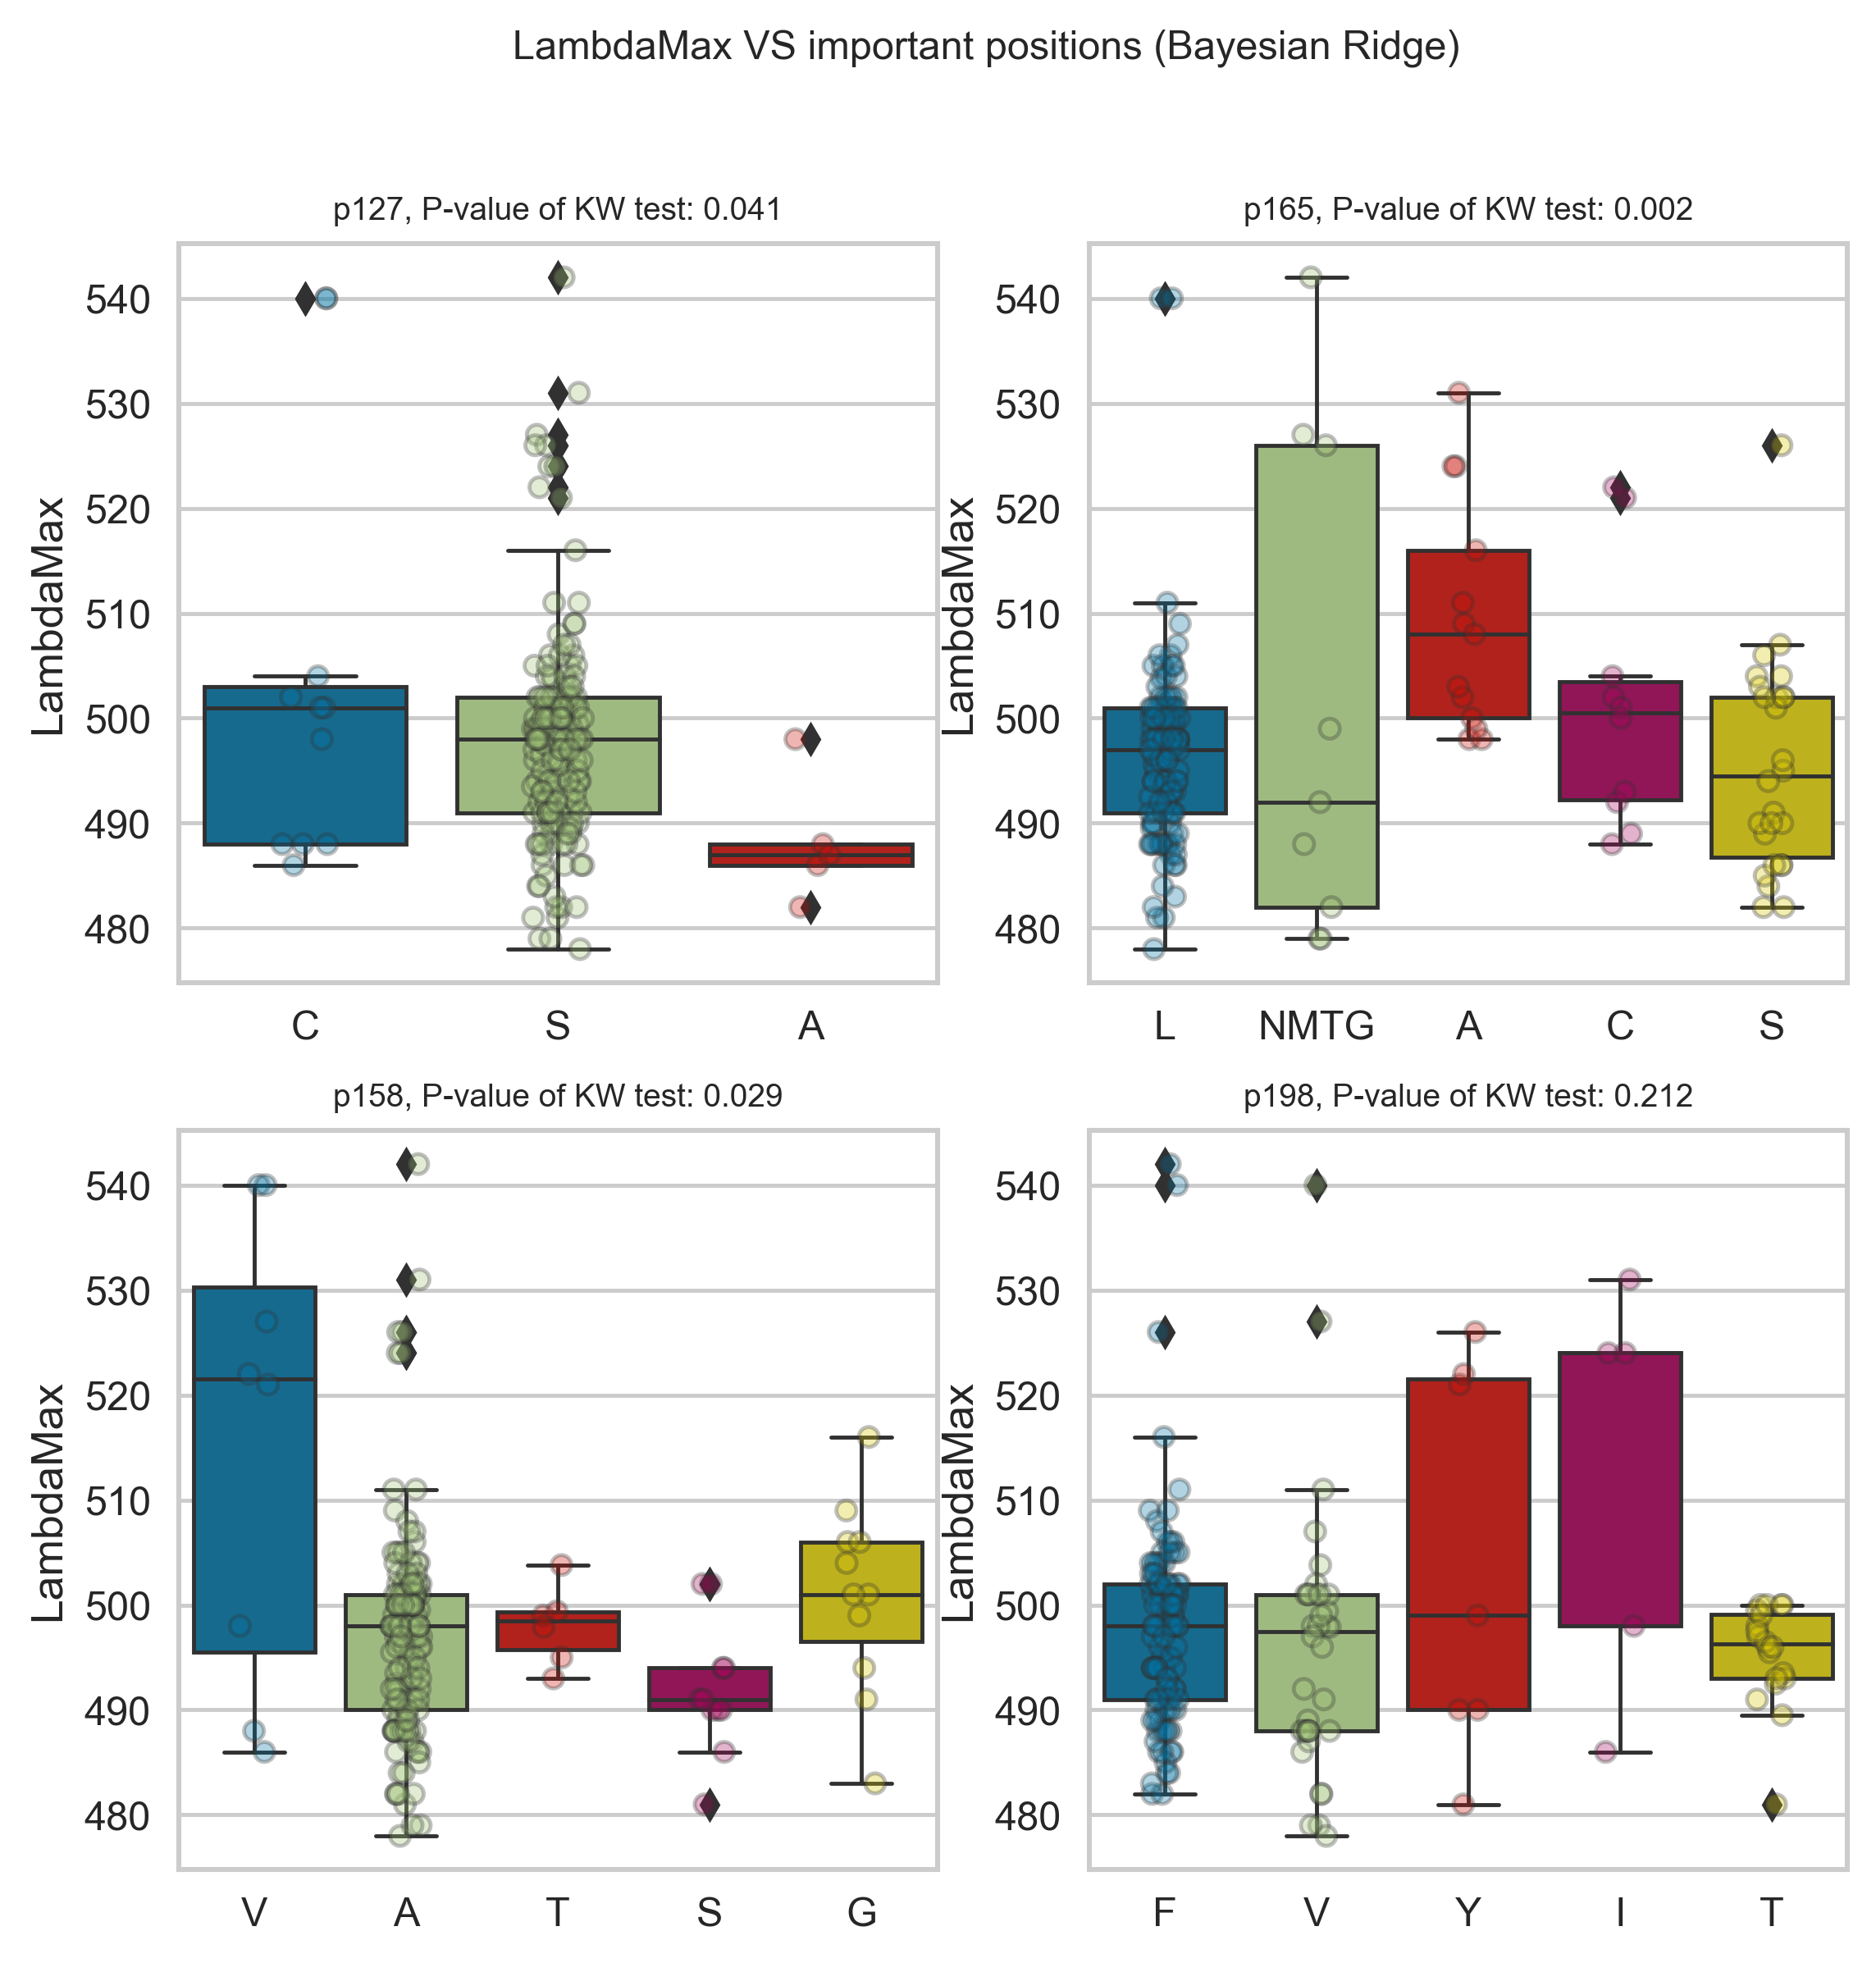

In [21]:
for i in range(models_to_select):
    # calculate the featre importances
    imp = ml.fimp_single(trained_model=top_models[i], model_name=model_names[i],
                         train_cols=train_cols, grouped_features=dc,
                         n_positions=positions, report_dir=report_dir)
    # visualize the lollipop plot for features based on each model
    viz.dp_plot(dat = imp, model_name= model_names[i],imp_col='standard_value', report_dir=report_dir)
    
    # visualize the boxplots for features based on each model
    viz.plot_imp_model(dat=df, trained_model=top_models[i],
                       model_name=model_names[i],
                       train_cols=train_cols, grouped_features=dc,
                       meta_var=mt, n_positions=positions,
                       model_type=anaType, report_dir=report_dir)

meanDone


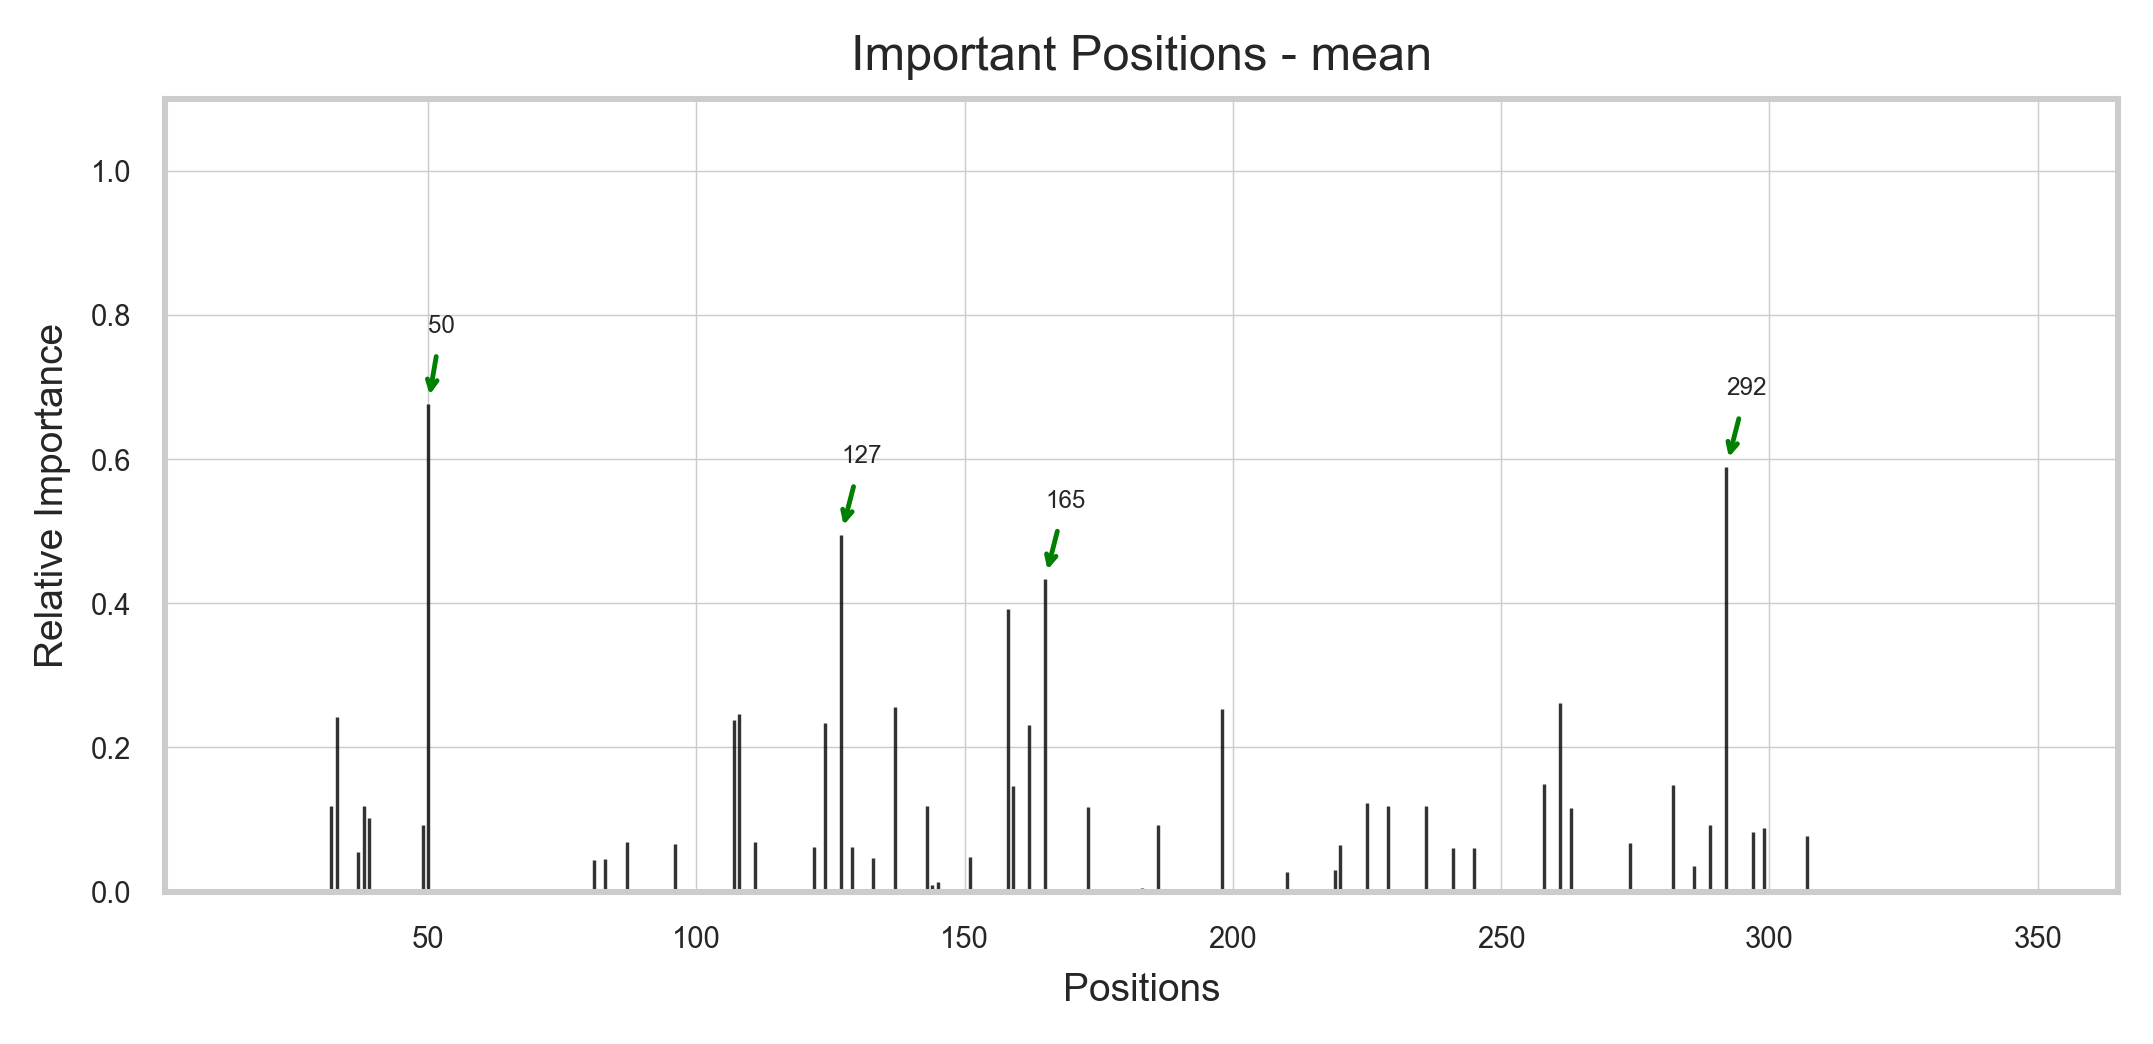

In [22]:
# merging the results for all the top models
mean_imp = ml.fimp_top_models(trained_models=top_models, model_names=model_names, 
                              train_cols=train_cols,grouped_features=dc,
                              n_positions=positions,report_dir=report_dir)

# lollipop plot for the merged results
viz.dp_plot(dat=mean_imp,figsize=(7.2, 3)
            model_name= 'mean',
            imp_col='mean_imp', 
            report_dir=report_dir)

{'p292': (<Figure size 1400x1400 with 1 Axes>,
  <AxesSubplot:title={'center':'p292, P-value of KW test: 0.0'}, ylabel='LambdaMax'>),
 'p50': (<Figure size 1400x1400 with 1 Axes>,
  <AxesSubplot:title={'center':'p50, P-value of KW test: 0.002'}, ylabel='LambdaMax'>),
 'p158': (<Figure size 1400x1400 with 1 Axes>,
  <AxesSubplot:title={'center':'p158, P-value of KW test: 0.029'}, ylabel='LambdaMax'>),
 'p165': (<Figure size 1400x1400 with 1 Axes>,
  <AxesSubplot:title={'center':'p165, P-value of KW test: 0.002'}, ylabel='LambdaMax'>),
 'p261': (<Figure size 1400x1400 with 1 Axes>,
  <AxesSubplot:title={'center':'p261, P-value of KW test: 0.0'}, ylabel='LambdaMax'>),
 'p127': (<Figure size 1400x1400 with 1 Axes>,
  <AxesSubplot:title={'center':'p127, P-value of KW test: 0.041'}, ylabel='LambdaMax'>),
 'p83': (<Figure size 1400x1400 with 1 Axes>,
  <AxesSubplot:title={'center':'p83, P-value of KW test: 0.009'}, ylabel='LambdaMax'>),
 'p173': (<Figure size 1400x1400 with 1 Axes>,
  <AxesSu

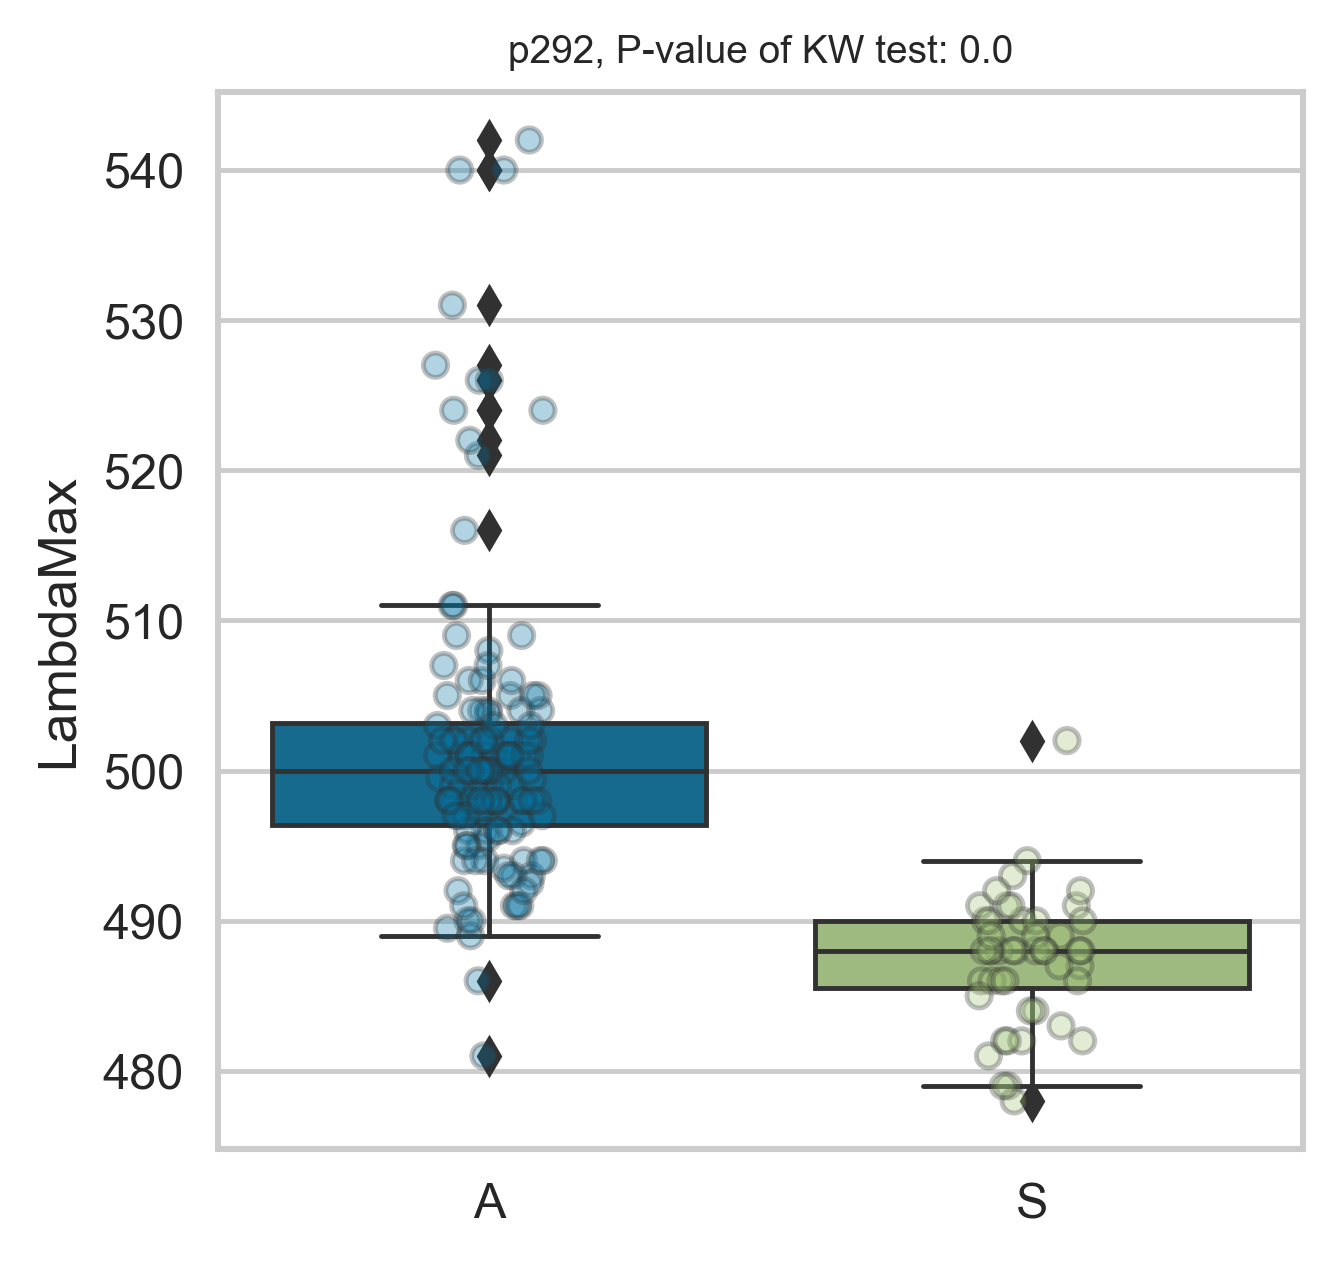

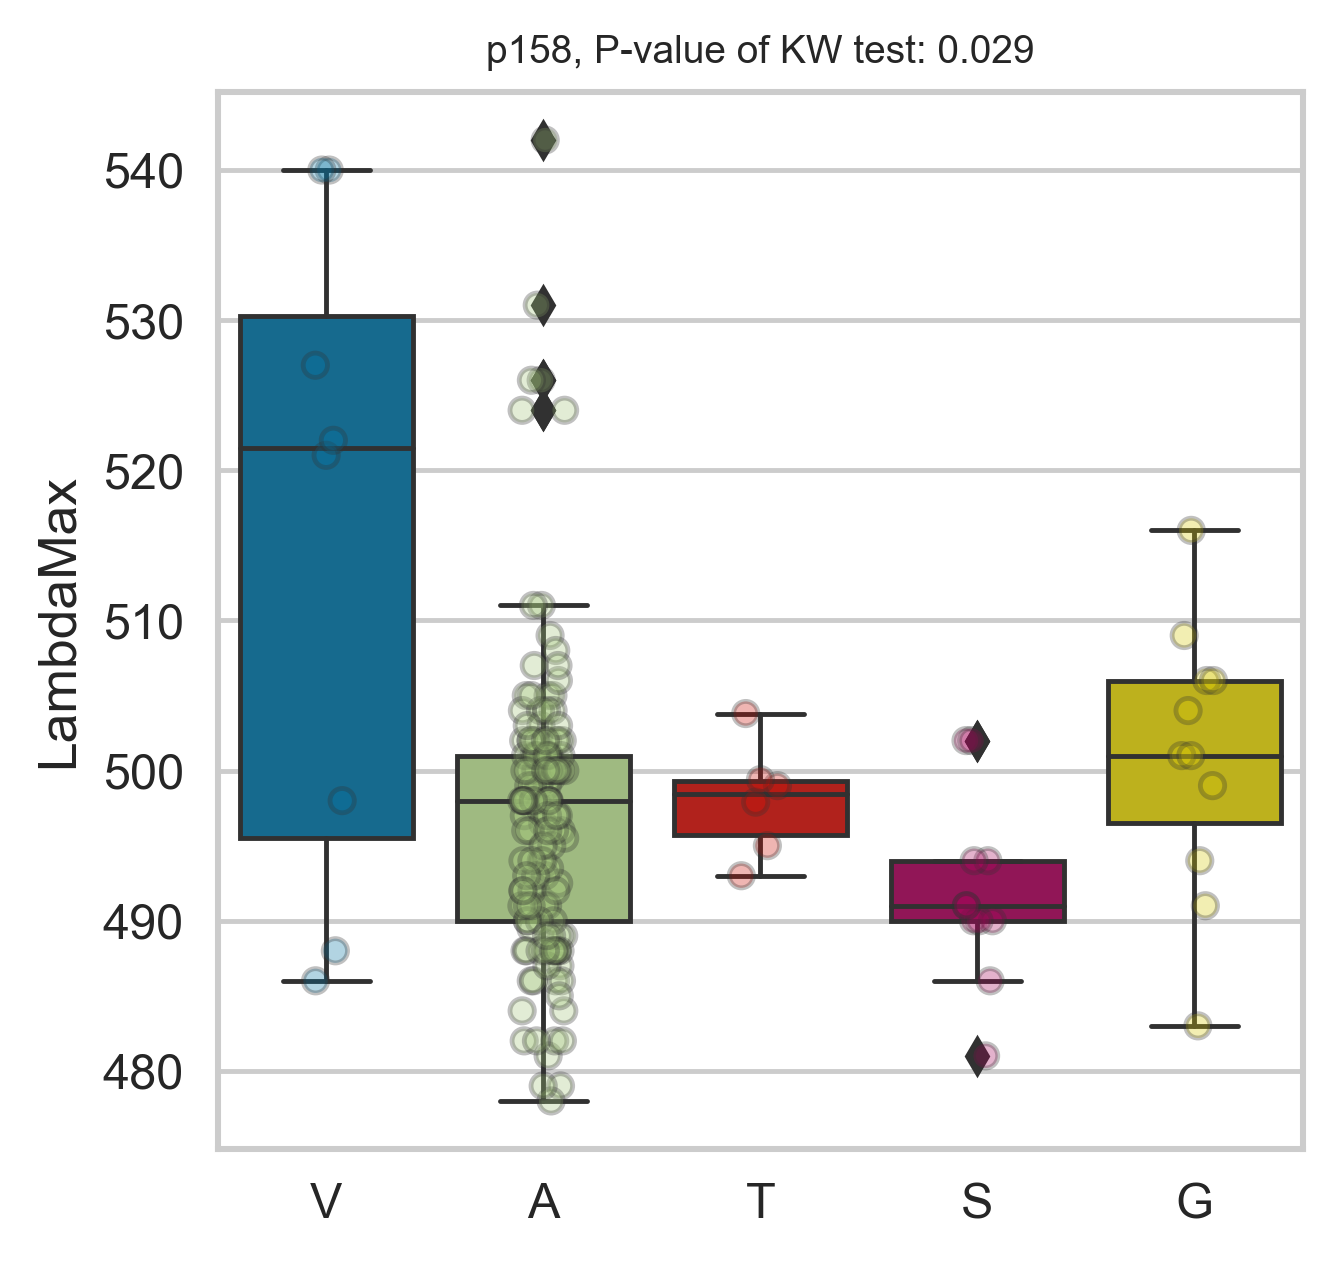

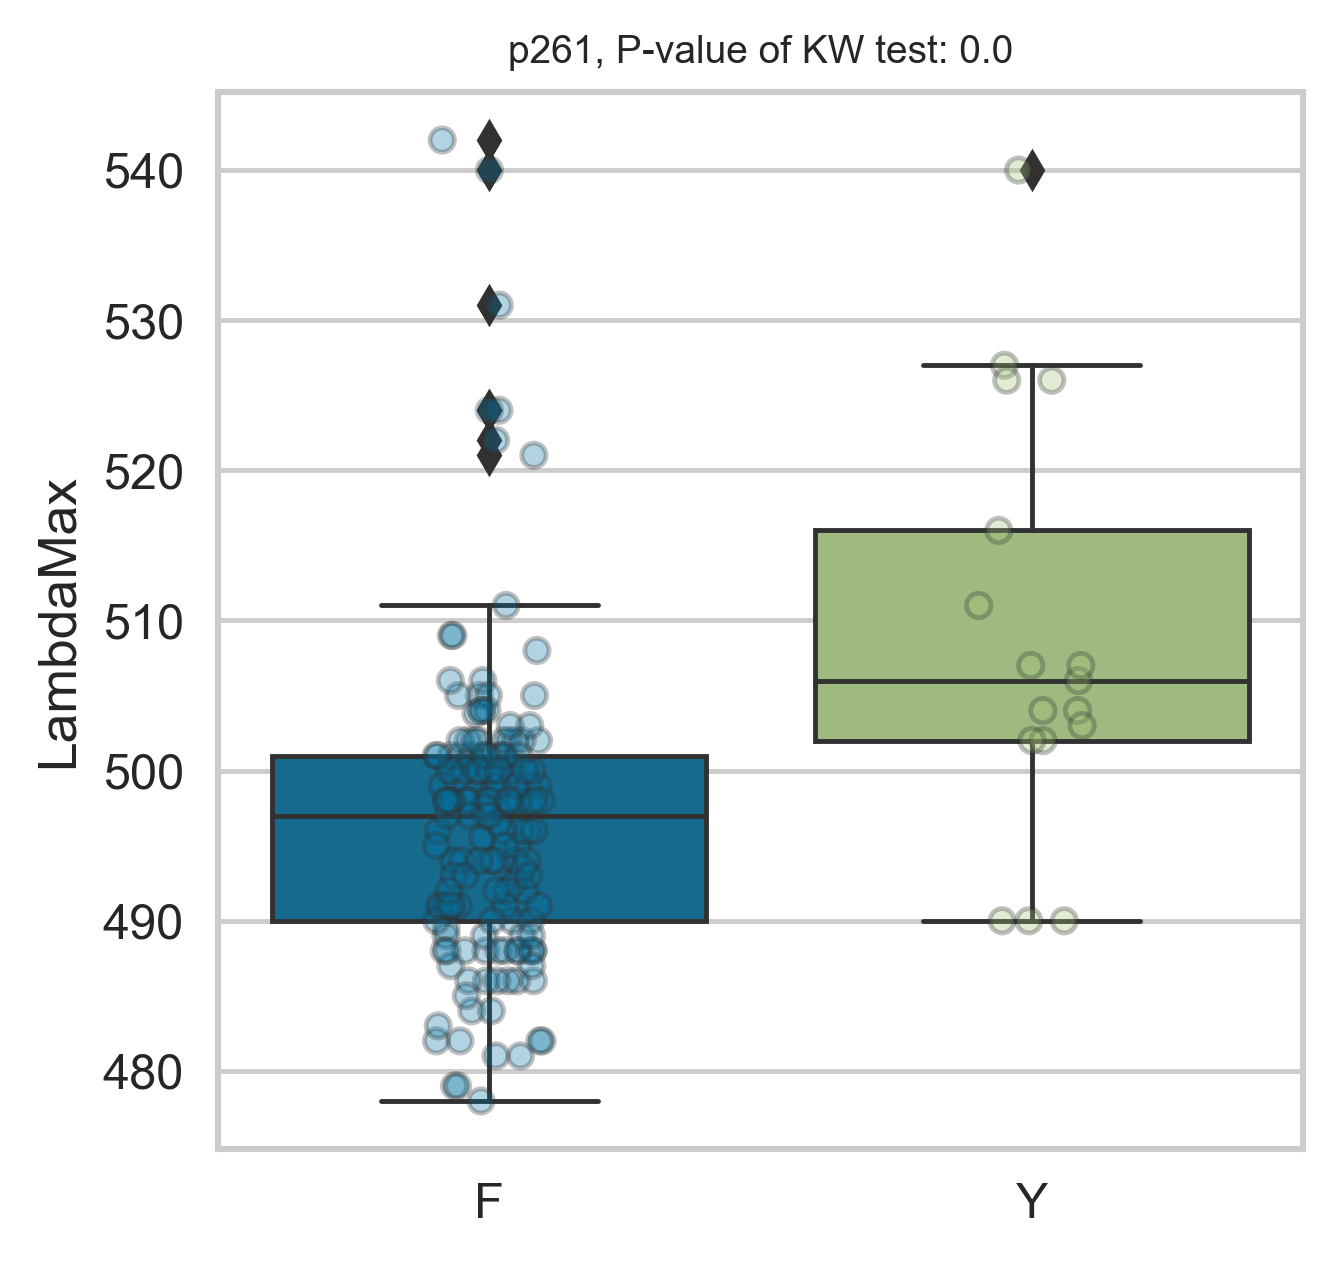

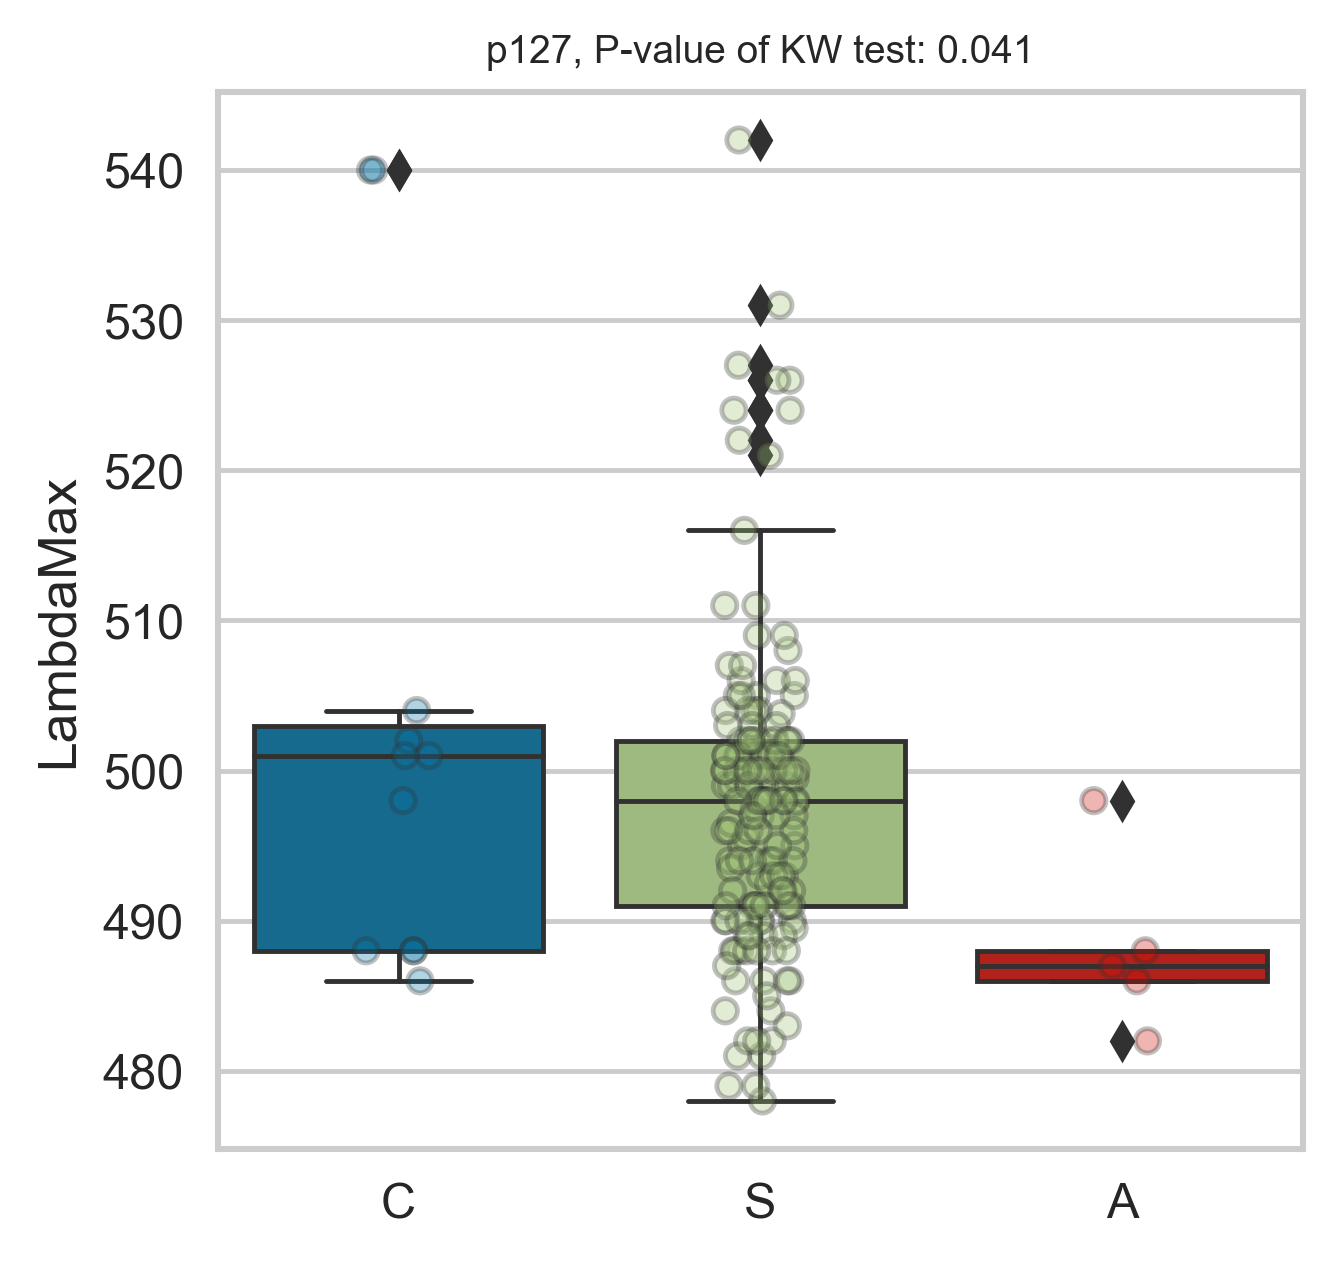

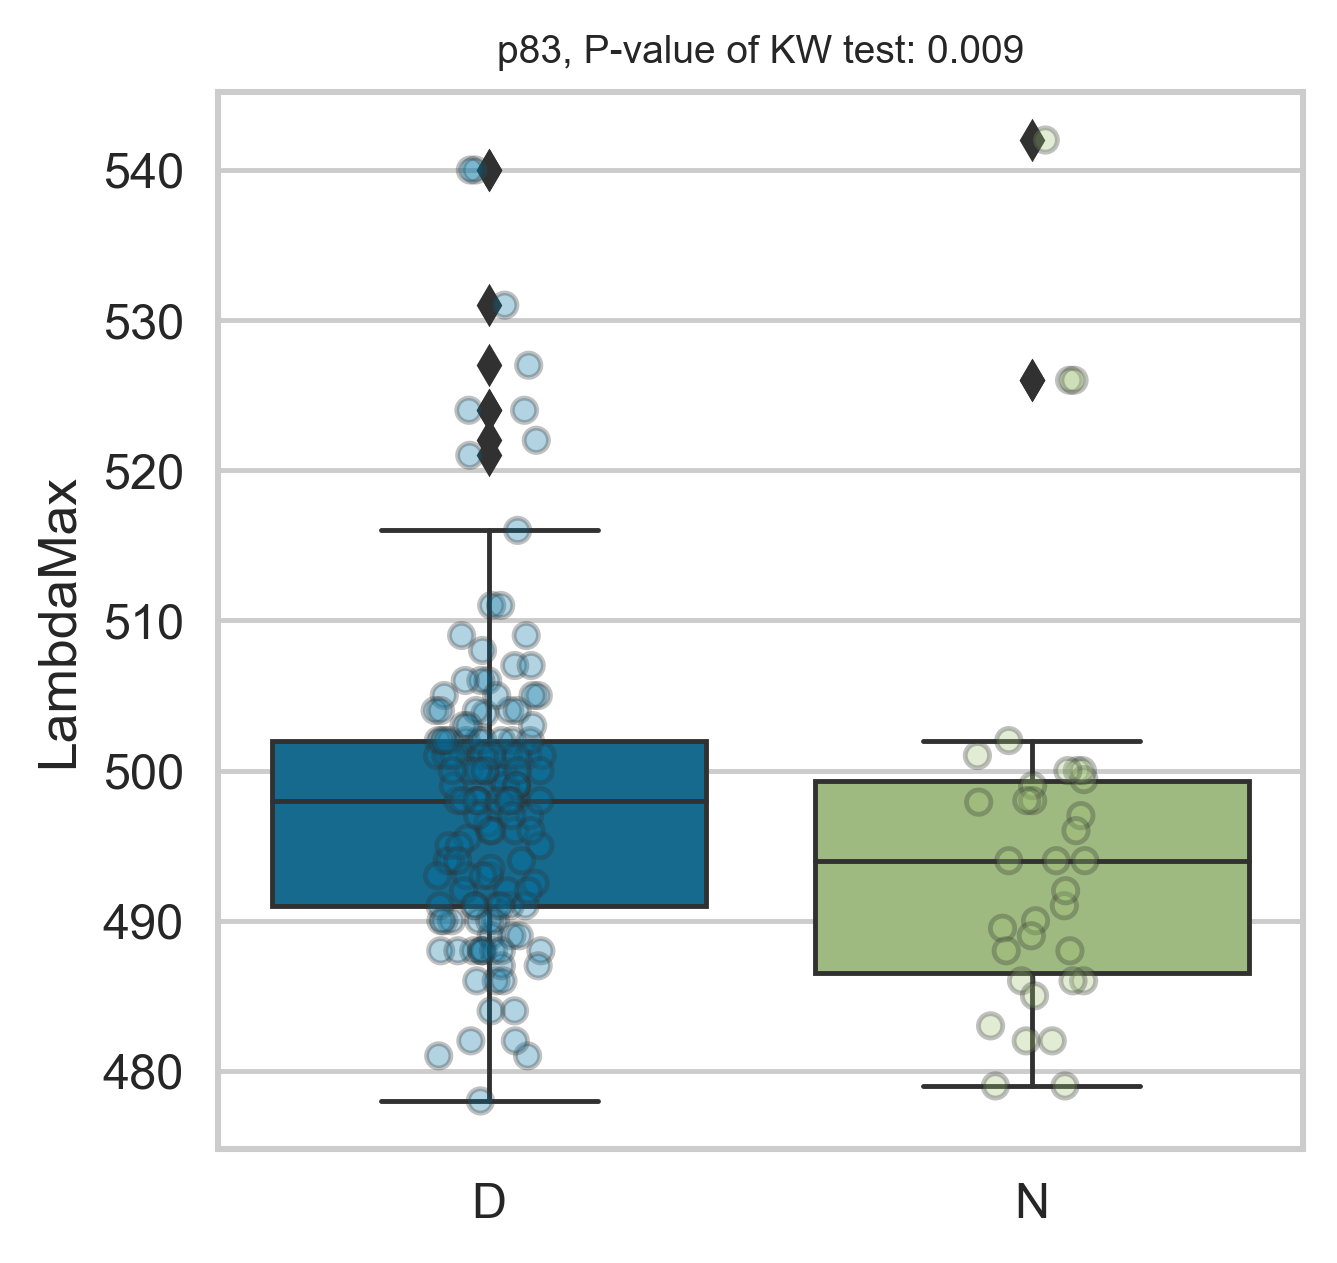

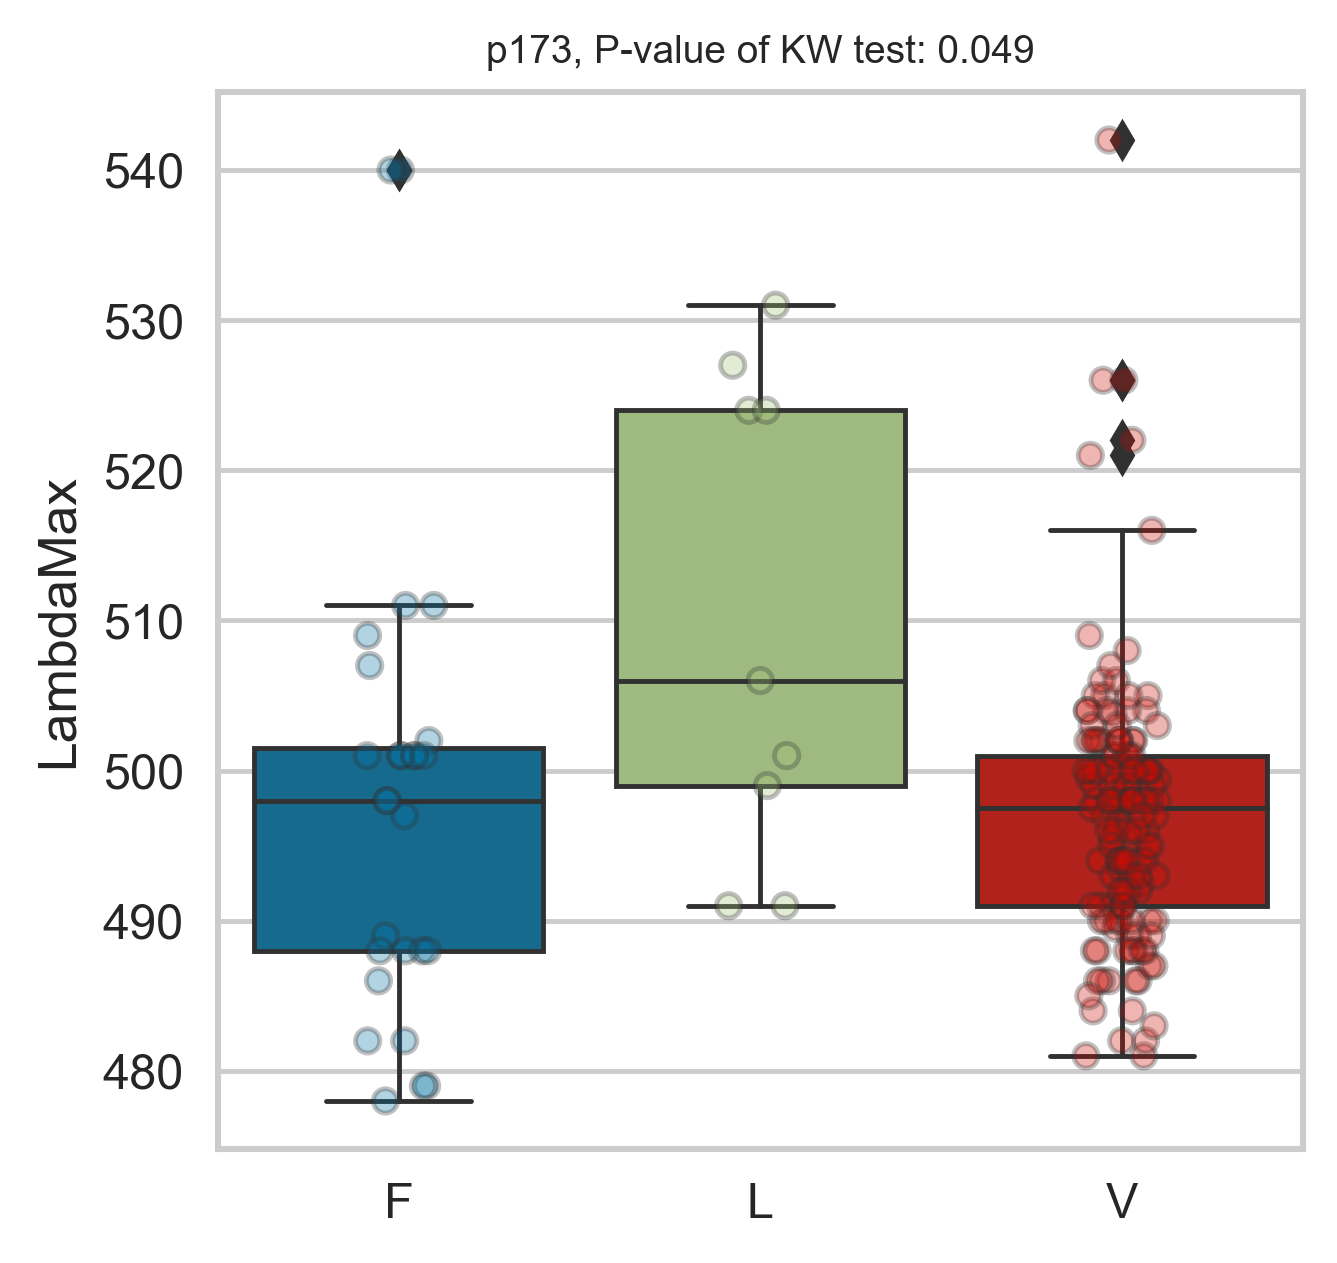

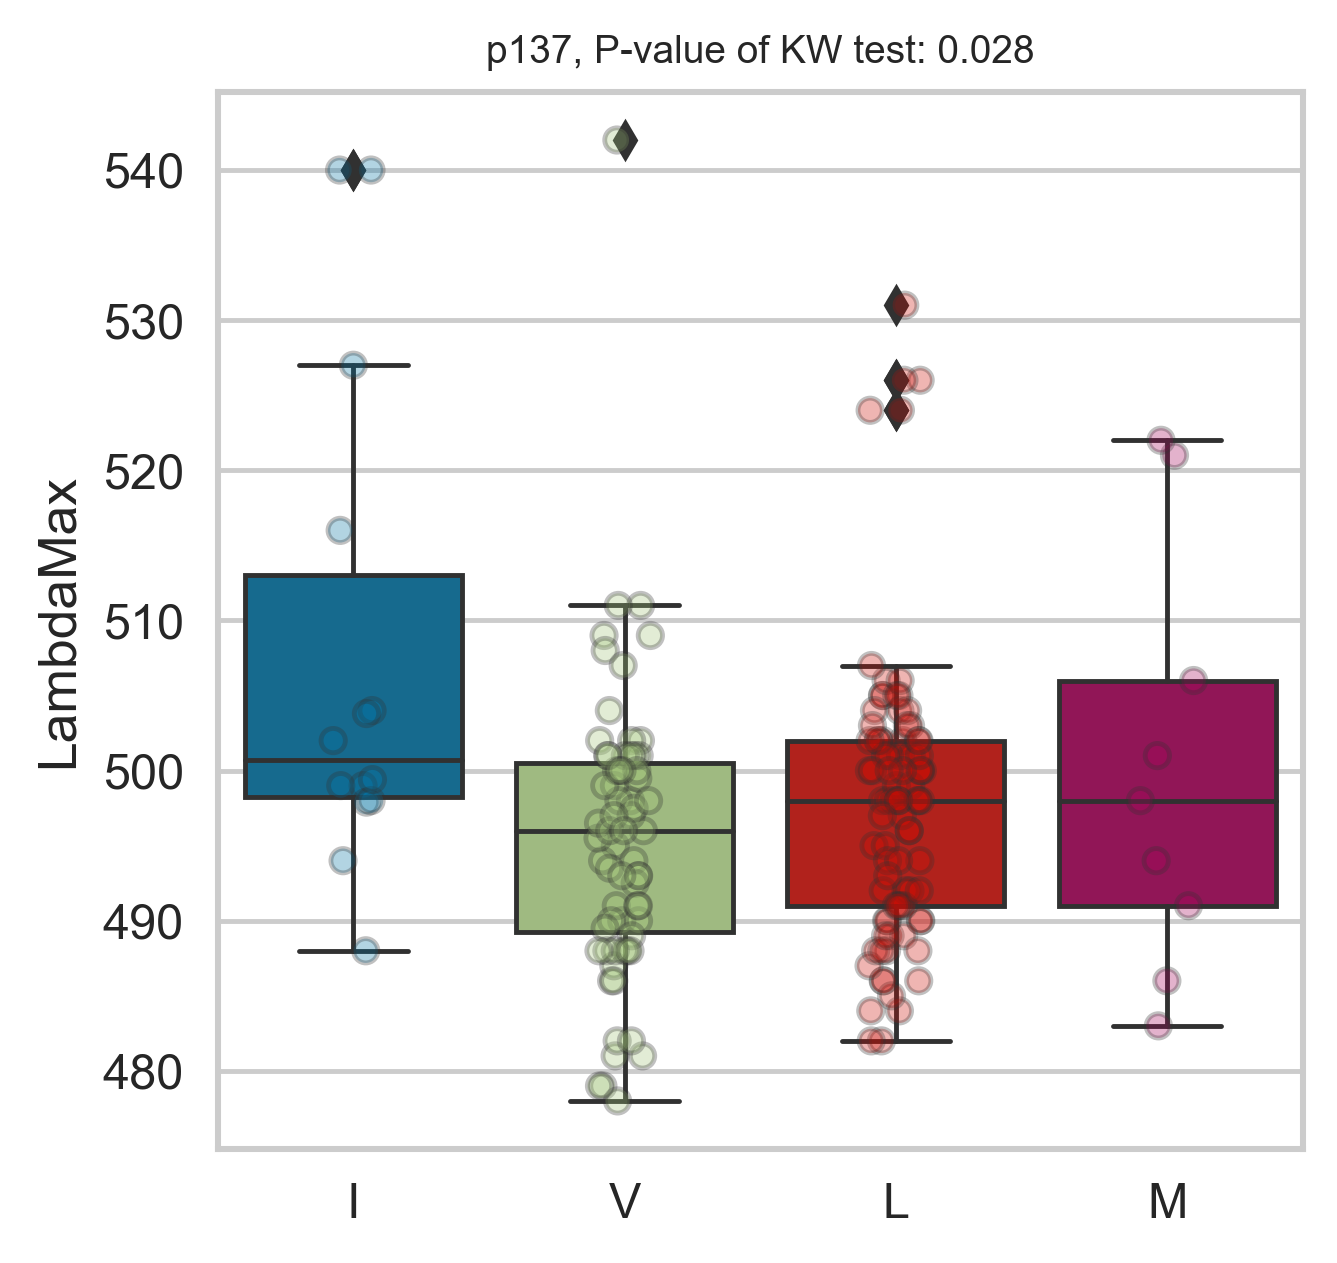

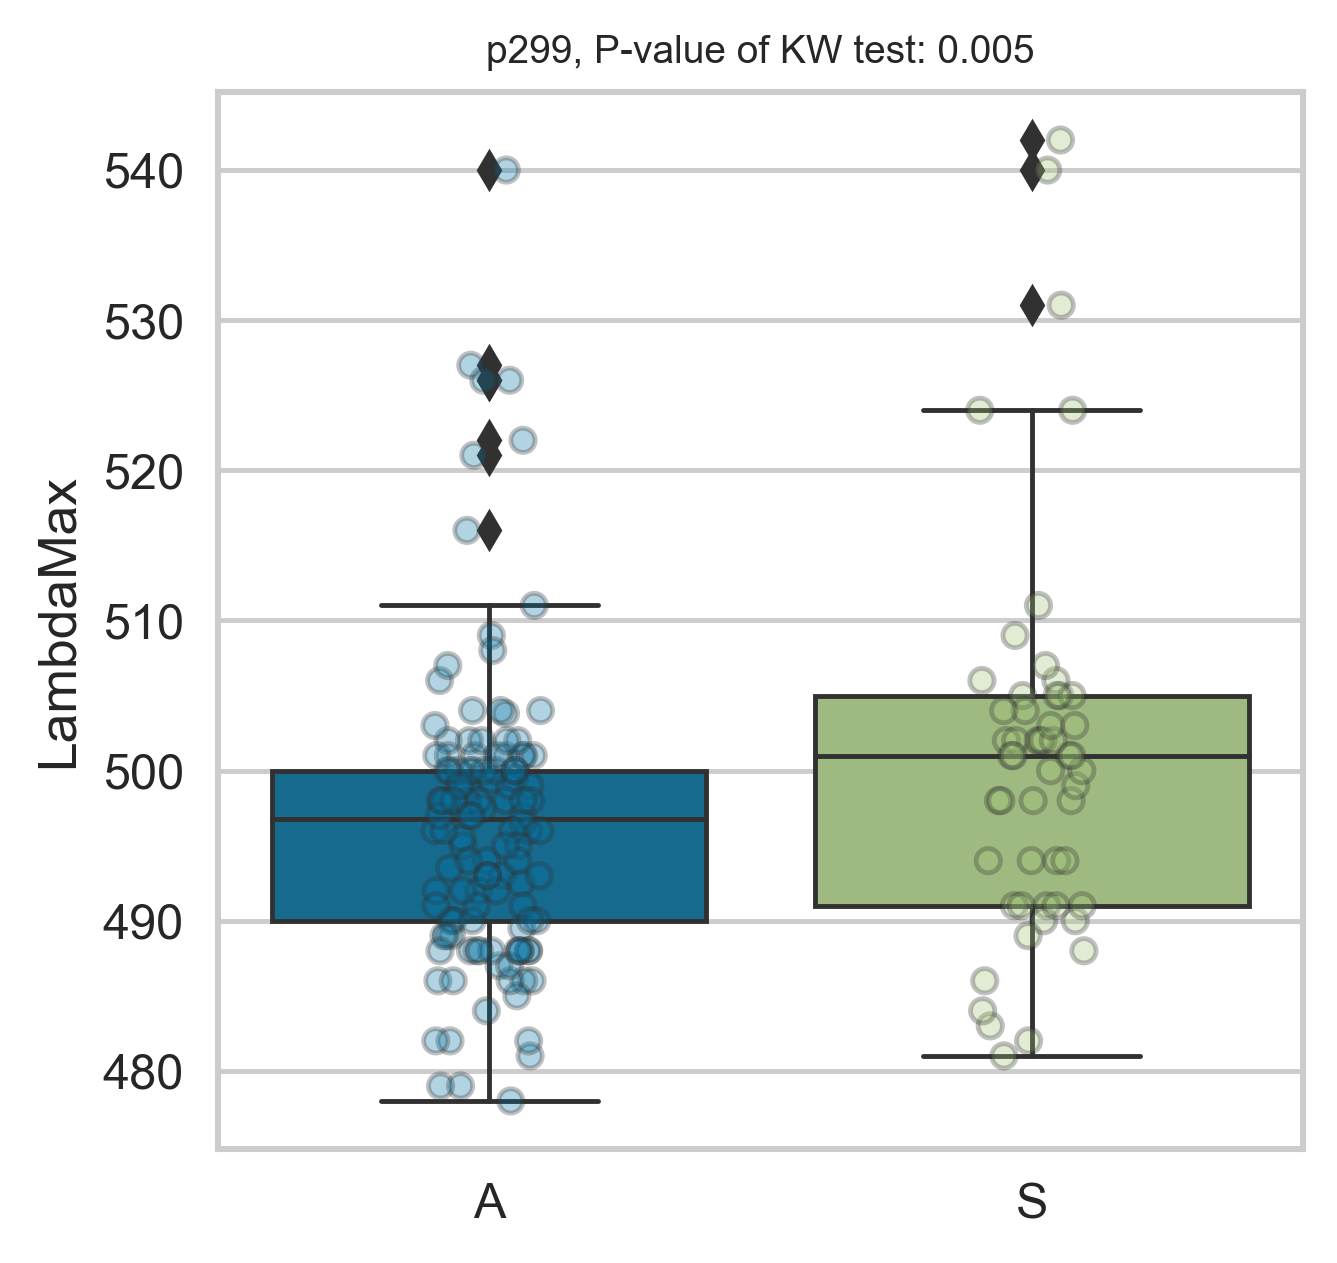

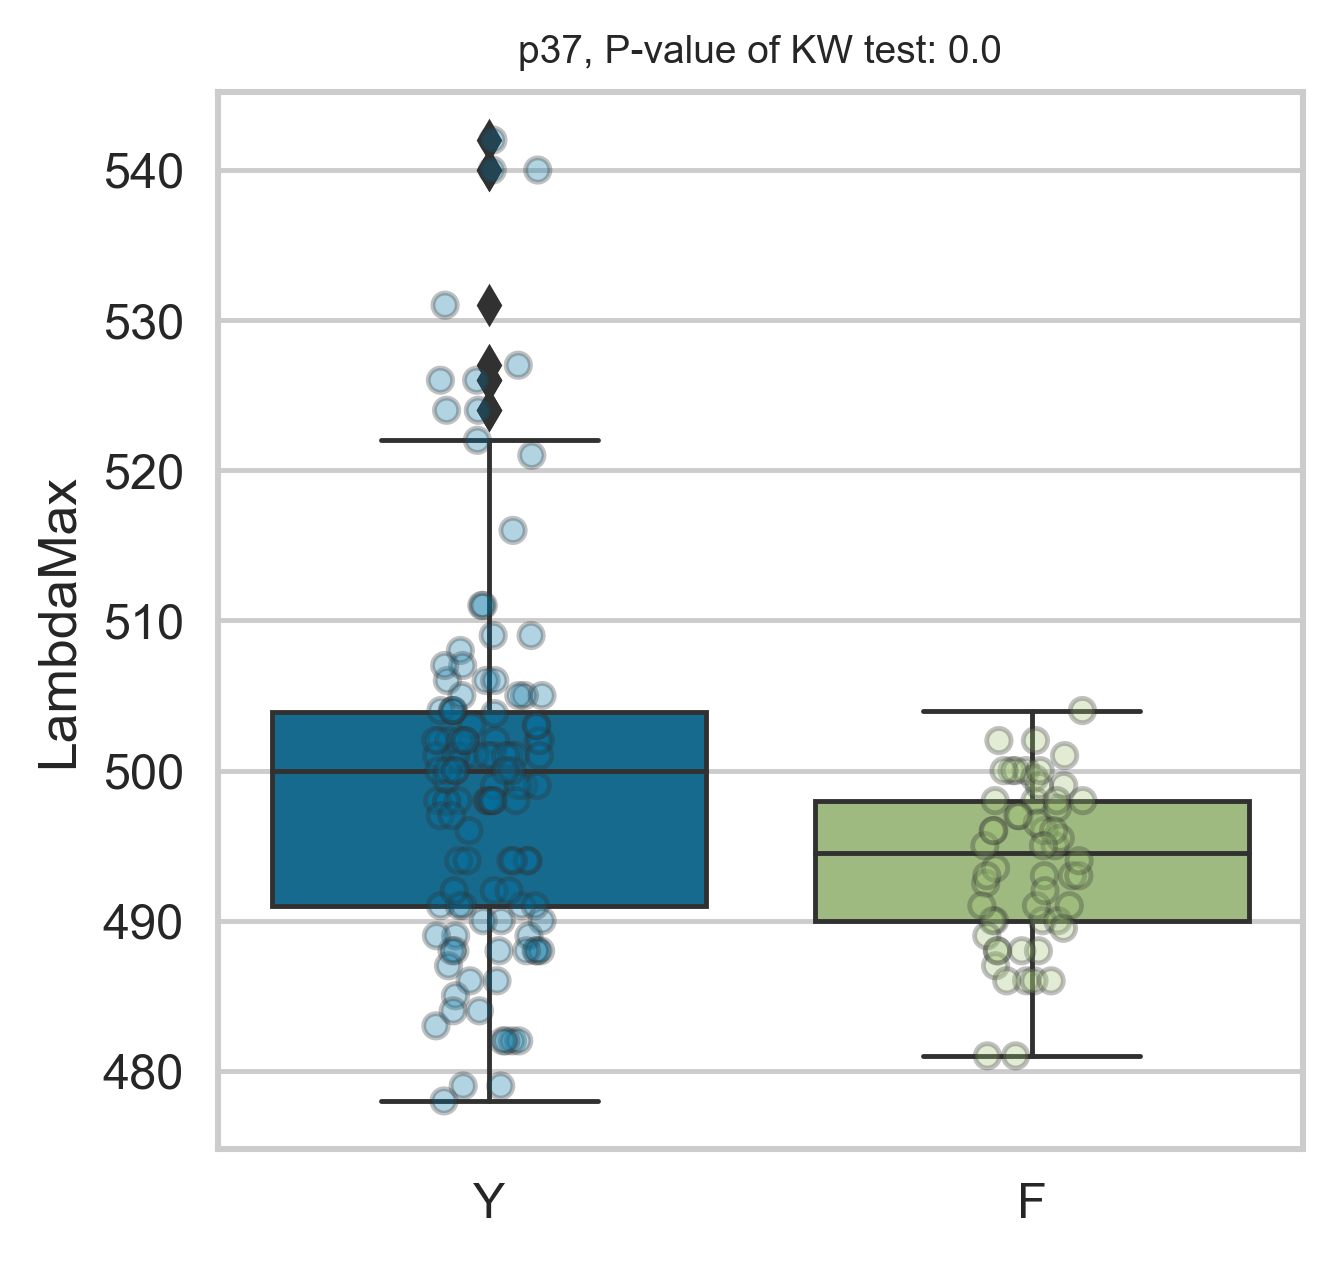

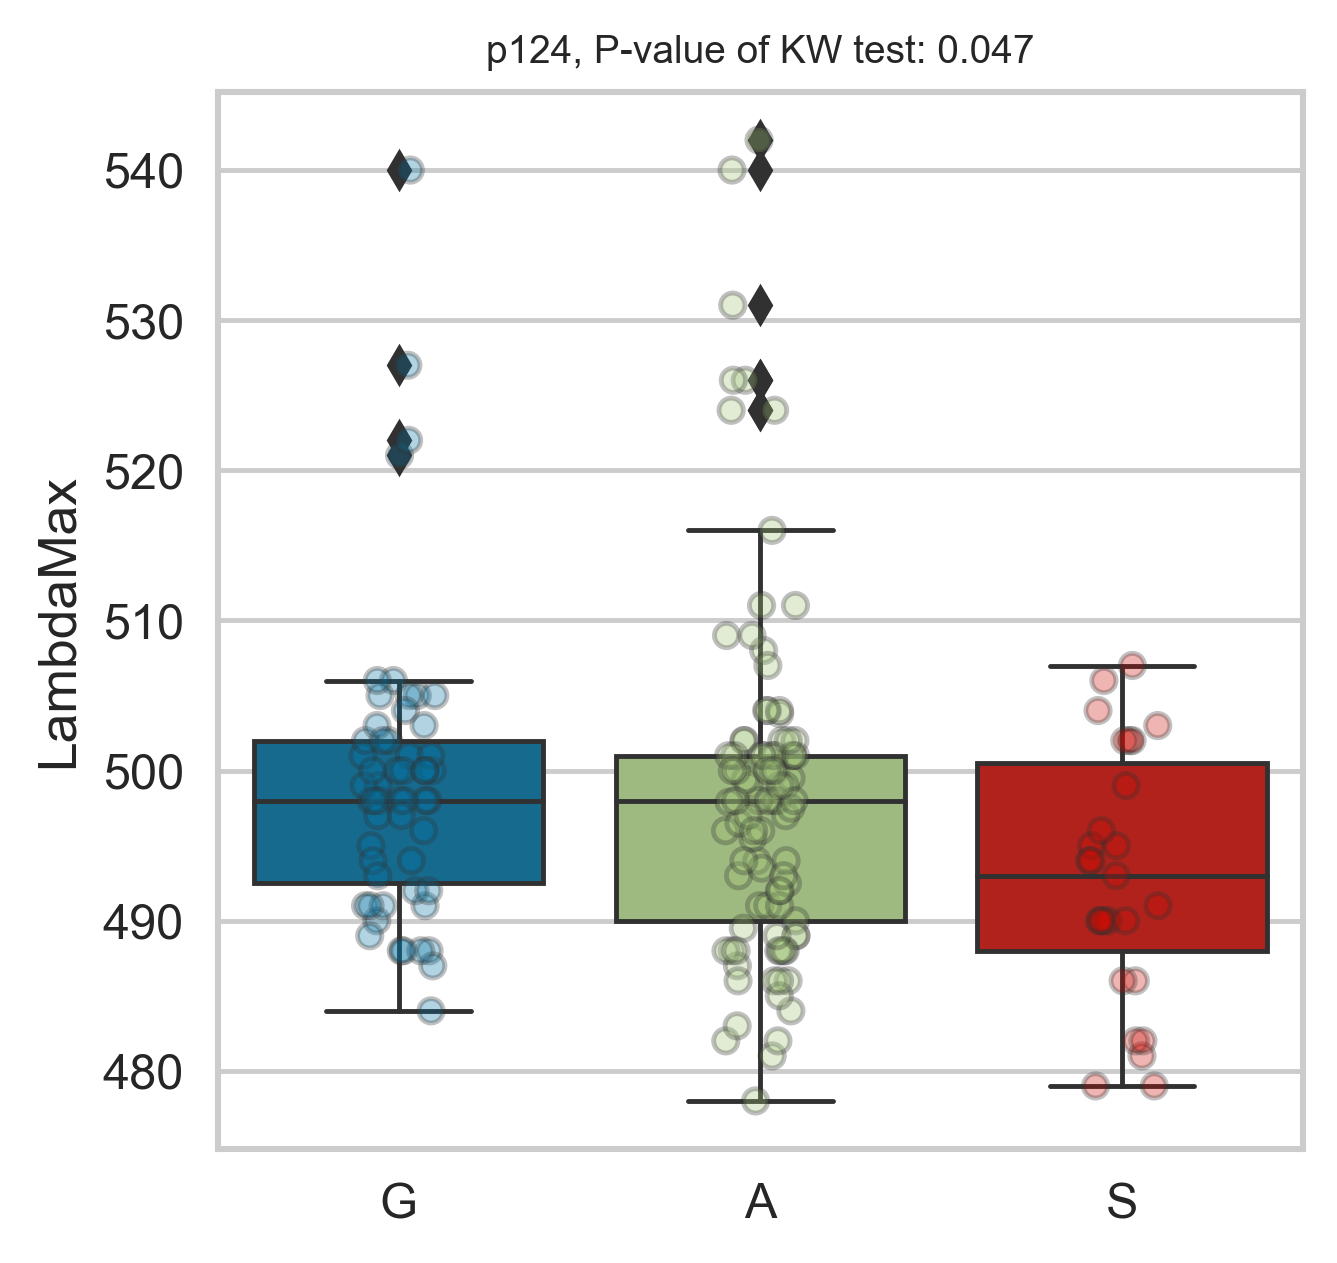

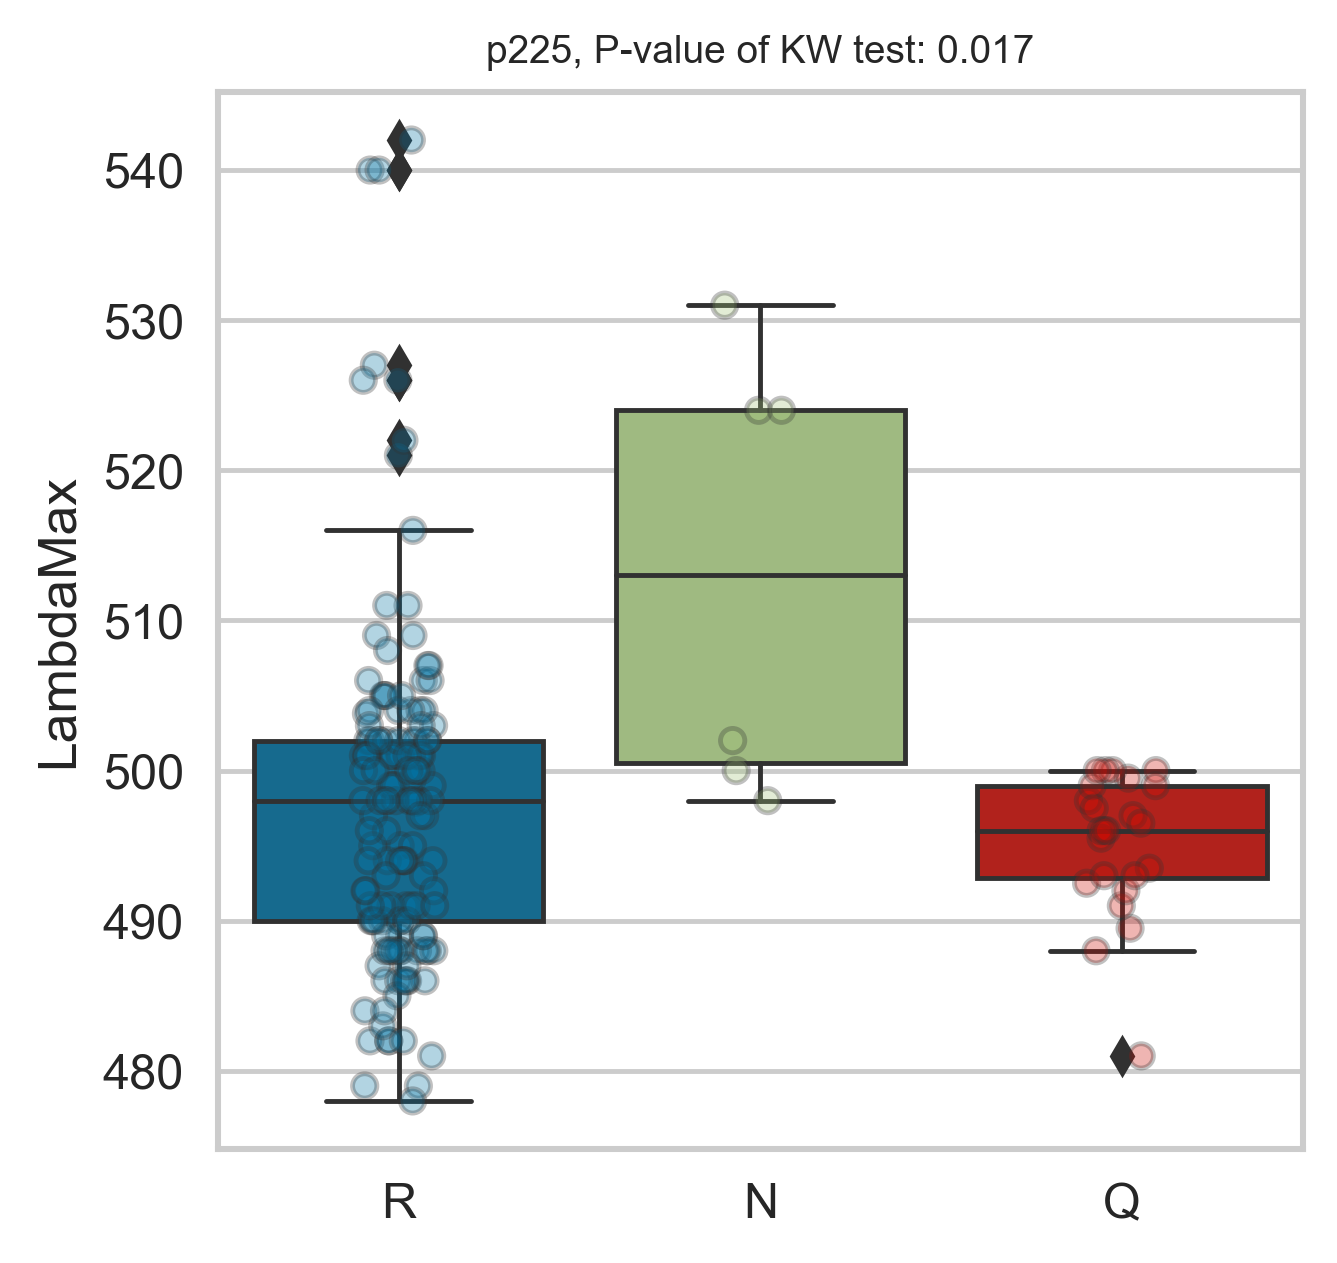

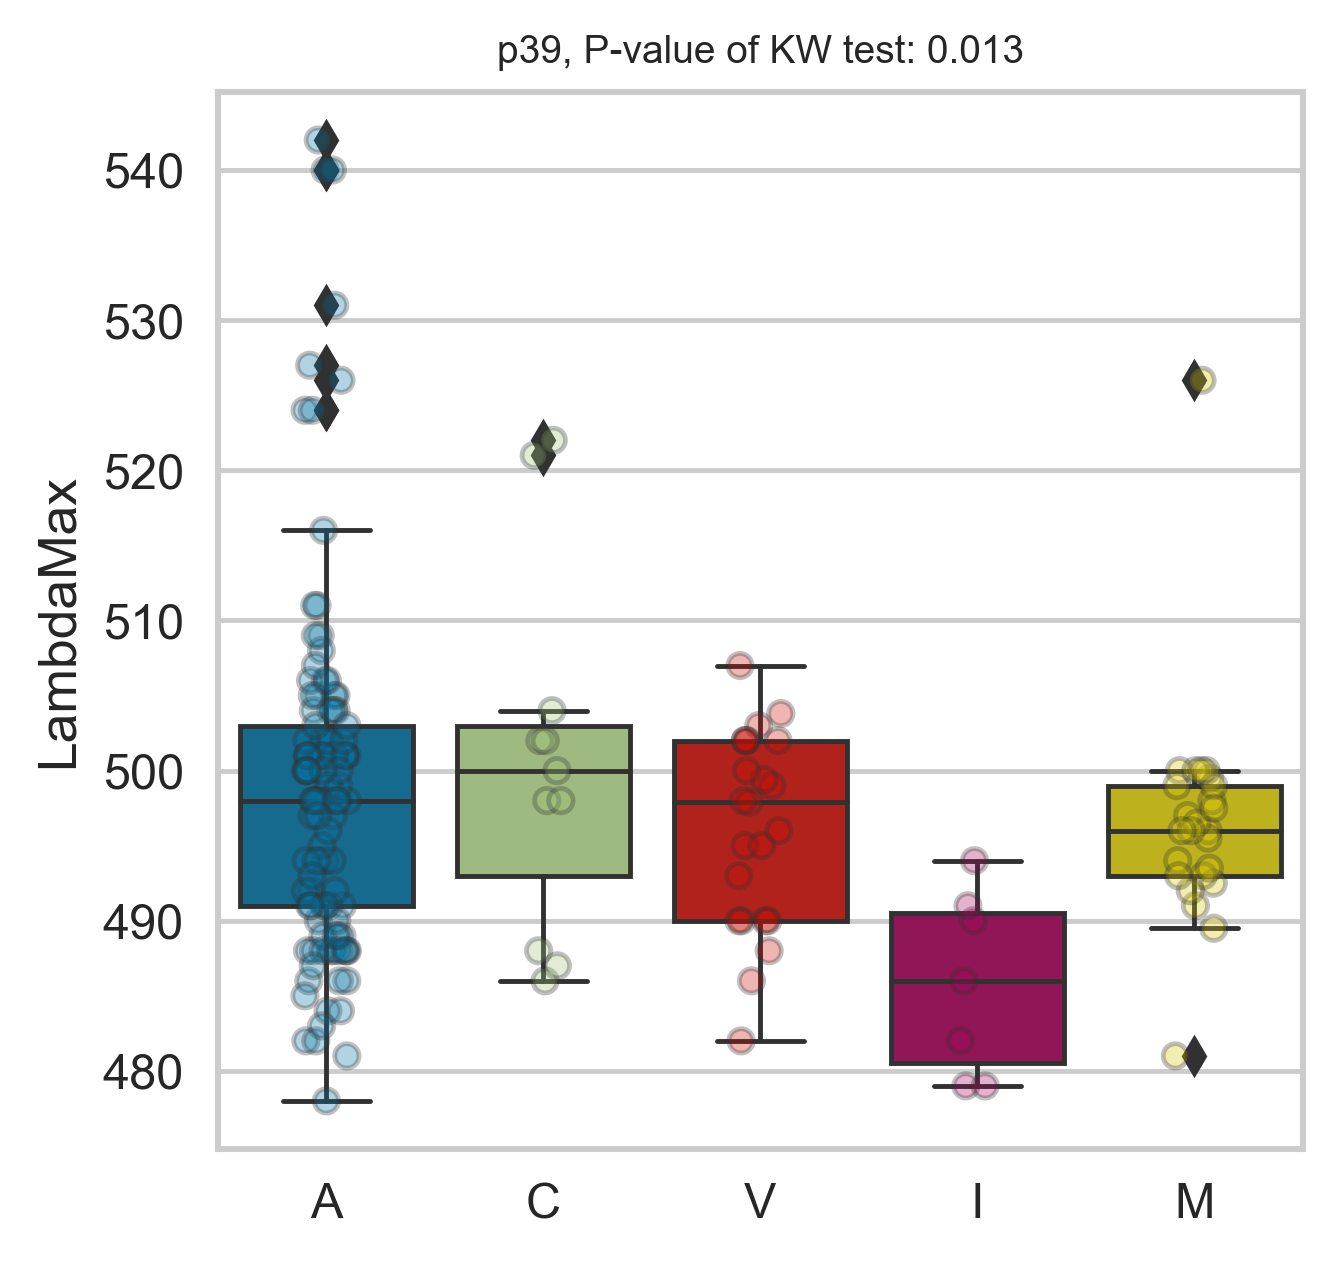

In [23]:
# visualizing top positions  
viz.plot_imp_all(trained_models=top_models, dat=df, train_cols=train_cols,
                 grouped_features=dc, meta_var=mt, model_type=anaType,
                 n_positions=positions, report_dir=report_dir)